# Title
Predicting Loan Default Risk - Leveraging Data for Smarter Credit Decisions

By Oluwaseun Adeyemi | August 28, 2025

# Introduction
Financial institutions rely on interest and fees from loans, making accurate prediction of credit default risk essential for minimizing losses and maintaining public trust.

This project applies advanced machine learning techniques to assess borrower characteristics—such as age, income, and employment status—and improve predictive accuracy.

A comparative analysis of five models—Logistic Regression, Random Forest, Decision Tree, XGBoostand AdaBoost is conducted. The study systematically evaluates data preprocessing, outlier handling, class imbalance correction, and feature selection to enhance model performance and support more informed lending decisions.

# Problem Statement
To develop a robust machine learning pipeline to predict loan default risk, enabling better credit decisions and minimizing financial losses. At the time of default, what is the remaining loan balance the borrower owes, and what portion of it will result in a loss for the lender? 
Three (3) different datasets were given for this analysis.

Customer behavioral and financial data will be used to build a predictive model, enhancing accuracy and efficiency in risk assessment.

# Importing the neccessary libraries

In [1]:
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading dataset
This project uses three datasets — Performance, Demographics, and Previous Loans. 
Each will be analyzed individually, clean and thereafter merged. 
Using pandas.read_csv(), datasets were loaded from their respective GitHub URLs.

In [2]:
url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv" 
url2: "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv" 
url3 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv"

# DATA INSPECTION, UNDERSTANDING AND CLEANING INDIVIUAL DATASET

# Performance dataset

# Performance Data (trainperf.csv)

This dataset contains information about **repeat loans** taken by customers. 
The goal is to predict whether a given loan will **default**, based on the customer's previous loans and demographics.

| Column Name       | Description |
|------------------|-------------|
| **customerid**    | Primary key used to merge with other datasets. Each customer has a unique ID. |
| **systemloanid**  | The unique ID for a particular loan. The same `customerid` can have multiple `systemloanid`s for each loan taken. |
| **loannumber**    | The sequence number of the loan that needs to be predicted. |
| **approveddate**  | Date when the loan was approved. |
| **creationdate**  | Date when the loan application was created. |
| **loanamount**    | The principal amount of the loan taken by the customer. |
| **totaldue**      | Total repayment required to settle the loan (principal + interest + fees). |
| **termdays**      | Duration of the loan in days. |
| **referredby**    | `customerid` of the customer who referred this person. If missing, the customer was not referred. |
| **good_bad_flag** | Target variable: indicates loan performance. `good` = loan settled on time, `bad` = loan not settled on time. |

# Loading data set

In [3]:
url1 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv"
Performance = pd.read_csv(url1)

In [4]:
# checking the summary info of the dataset
Performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [5]:
# checking the number of rows(4368) and columns(10)
Performance.shape

(4368, 10)

In [6]:
# checking for duplicate -- there is no duplicate
Performance.duplicated().sum()

0

In [7]:
Performance.describe()

systemloanid   loannumber    loanamount      totaldue     termdays
count  4.368000e+03  4368.000000   4368.000000   4368.000000  4368.000000
mean   3.019810e+08     5.172390  17809.065934  21257.377679    29.261676
std    1.343115e+04     3.653569  10749.694571  11943.510416    11.512519
min    3.019585e+08     2.000000  10000.000000  10000.000000    15.000000
25%    3.019691e+08     2.000000  10000.000000  13000.000000    30.000000
50%    3.019801e+08     4.000000  10000.000000  13000.000000    30.000000
75%    3.019935e+08     7.000000  20000.000000  24500.000000    30.000000
max    3.020040e+08    27.000000  60000.000000  68100.000000    90.000000

# Interpretation of descriptive statistics for the loan dataset:

| Feature          | Interpretation                                                                                                                                                                                                                                                                 |
| ---------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **systemloanid** | Unique identifier for each loan. The `count` equals 4368, indicating no missing IDs. The mean and std aren’t meaningful for IDs, but min/max show the range of IDs.                                                                                             |
| **loannumber**   | Seems to represent the sequential loan number per customer. Mean \~5.17, median 4, max 27. Most customers have fewer than 7 loans (`75% = 7`), suggesting repeat loans are less common.                                                                                        |
| **loanamount**   | The average loan is \~17,809, with a standard deviation of 10,750, showing a wide range of loan sizes. The min is 10,000, max 60,000, and the median is 10,000 — meaning many loans are at the lower end, but a few large loans increase the mean (right-skewed distribution). |
| **totaldue**     | Average total due is 21,257, higher than the average loan amount, suggesting interest and fees. Similar skewness to loanamount, with min = 10,000, max = 68,100. The median (13,000) is closer to the 25th percentile, again indicating a right-skewed distribution.           |
| **termdays**     | Average loan term \~29 days, with a standard deviation of 11.5. Most loans have terms of 30 days (`50% = 30`, `75% = 30`), but there are longer-term loans up to 90 days. The min is 15 days. This indicates most loans are short-term, with a few longer-term outliers.       |

### Insights / Possible Actions

1. **Loan Amount Distribution:** Highly right-skewed; will be considered for log transformation when modeling.
2. **Term Days:** Most loans are 30 days, so modeling may treat 30-day loans as the standard category. Outliers (15 or 90 days) may need special attention.
3. **Total Due vs Loan Amount:** The difference reflects fees/interest; considering analyzing effective interest rate per loan.
4. **Repeat Loans:** Most customers have fewer than 7 loans, but a few have many, which might influence risk profiling.

In [8]:
# checking for missing value -- there are missing values in a referredby column and this will be treated later.
Performance.isna().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [9]:
# Checking the percentage of missing values in each column
Performance.isna().sum().sort_values(ascending=False) / len(Performance) * 100

referredby       86.561355
customerid        0.000000
systemloanid      0.000000
loannumber        0.000000
approveddate      0.000000
creationdate      0.000000
loanamount        0.000000
totaldue          0.000000
termdays          0.000000
good_bad_flag     0.000000
dtype: float64

# Dropping irrelevant column

In [10]:
# checking the columns
Performance.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [11]:
# dropping the column - 
Performance.drop(['referredby'], axis=1, inplace=True)

In [12]:
# Previewing to see the Top 2 rowss after referred column was dropped
Performance.head(2)

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000     30000.0   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000     15000.0   

   totaldue  termdays good_bad_flag  
0   34500.0        30          Good  
1   17250.0        30          Good

In [13]:
# conversion of performance dataset to csv format so as to be able use it for future analysis
Performance.to_csv("perf_dataset.csv", index=False)

# FEATURE ENGINEERING

# Calculating features that impact Loan default risk
So i am calculating features that impact loan default risk because my goal is to predict which customers are likely to default and to understand the drivers behind default behavior.
This is also essential to:
 - improve model performance, 
 - provide actionable insights, 
 - identify risk drivers, 
 - handle sparse/imbalanced data, and 
 - make predictions interpretable for business decisions.

# Monthly payment
Estimated Income is an institution’s calculated guess of how much a borrower earns (monthly or yearly). 
It’s essential for measuring repayment ability and is used to derive risk ratios like loan-to-income and debt-to-income.

In [14]:
# Calculate monthly payment -- termdays / 30 converts the term to months (approximate)

Performance['monthly_payment'] = Performance['totaldue'] / (Performance['termdays'] / 30)

# Estimated income
Estimated income is the system’s or institution’s best guess of the borrower’s monthly or annual earnings.

Why *3:
 - This is an assumed multiplier representing the idea that the borrower’s annual income is roughly 3× the “term-adjusted loan amount”.
 - It’s a heuristic to make the estimated income larger than the raw loan amount, producing a more realistic Debt-to-Income Ratio.

In [15]:
# Calculate estimated income

# first calculate Monthly payment
Performance["monthly_payment"] = Performance["totaldue"] / (Performance["termdays"] / 30)

# Estimate income using loan amount and term  -- # Here, factor = 3 (you can tune based on historical data)
Performance["estimated_income"] = Performance["loanamount"] * (12 / Performance["termdays"]) * 3

# Debt-to-income ratio (DTI)
 - Measures the proportion of a borrower’s monthly debt payments (including the loan in question) relative to their monthly income.
 - A lower DTI indicates better financial health and repayment capacity, while a higher DTI suggests a higher risk of default.

In [16]:
# Debt-to-Income Ratio (sum of all monthly payments / monthly income)
Performance['debt_to_income_ratio'] = Performance['monthly_payment'] / Performance['estimated_income']

# Loan-to-Income Ratio
 - Compares the total loan amount to a borrower’s income.
 - It indicates how large the loan is relative to the borrower’s earnings and helps assess their ability to repay the loan.
 - A higher ratio suggests the loan is a larger burden on the borrower’s income, potentially increasing default risk, while a lower ratio indicates more manageable debt levels.

In [17]:
# Loan-to-Income Ratio (Loan amount / Annual income)

Performance['loan_to_income_ratio'] = (Performance['loanamount'] / Performance['estimated_income'])

# Outstanding ratio 
The ratio of outstanding loan amount to total approved or borrowed amount (sometimes loan-to-value or loan-to-income).
 - A high outstanding ratio indicates the borrower still owes a significant portion of the loan, increasing default risk. 
 - Lower ratios suggest the borrower is repaying steadily.

In [18]:
# Outstanding ratio 
Performance['outstanding_ratio'] = Performance['totaldue'] / Performance['loanamount']

# High-risk flag
 - Is a binary indicator (0/1) or label that marks borrowers considered high risk based on past behavior or model predictions
 - Borrowers flagged as high-risk are more likely to default, helping lenders focus monitoring or mitigation efforts.
Why thresholds (0.5 and 0.4)?
 - These come from credit risk industry benchmarks:
 - DTI > 40% is widely considered “high risk” (borrower is debt-burdened).
 - LTI > 50% indicates the loan size is large relative to income, which may strain repayment ability.
Banks, microfinance, and credit bureaus often use similar cutoffs to flag risky applicants.

In [19]:
# Flag high-risk loans based on thresholds (example thresholds)
Performance['high_risk_flag'] = ((Performance['loan_to_income_ratio'] > 0.5) | 
                        (Performance['debt_to_income_ratio'] > 0.4)).astype(int) 

# Approval Lag / Processing Time

 - This is the time taken for the loan to be approved after application.
 - Longer processing times might indicate stricter approval criteria or inefficiencies in the lending process, which could correlate with higher default risk.

In [20]:
# Calculate approval lag in days
# conversion of date to datetime format
Performance['creationdate'] = pd.to_datetime(Performance['creationdate'], errors='coerce')
Performance['approveddate'] = pd.to_datetime(Performance['approveddate'], errors='coerce')

Performance['approval_lag_days'] = (Performance['approveddate'] - Performance['creationdate']).dt.days

In [21]:
# previewing my top 2 rows
Performance.head(2)

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   

         approveddate        creationdate  loanamount  totaldue  termdays  \
0 2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1 2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   

  good_bad_flag  monthly_payment  estimated_income  debt_to_income_ratio  \
0          Good          34500.0           36000.0              0.958333   
1          Good          17250.0           18000.0              0.958333   

   loan_to_income_ratio  outstanding_ratio  high_risk_flag  approval_lag_days  
0              0.833333               1.15               1                  0  
1              0.833333               1.15               1                  0

In [22]:
Performance.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customerid            4368 non-null   object        
 1   systemloanid          4368 non-null   int64         
 2   loannumber            4368 non-null   int64         
 3   approveddate          4368 non-null   datetime64[ns]
 4   creationdate          4368 non-null   datetime64[ns]
 5   loanamount            4368 non-null   float64       
 6   totaldue              4368 non-null   float64       
 7   termdays              4368 non-null   int64         
 8   good_bad_flag         4368 non-null   object        
 9   monthly_payment       4368 non-null   float64       
 10  estimated_income      4368 non-null   float64       
 11  debt_to_income_ratio  4368 non-null   float64       
 12  loan_to_income_ratio  4368 non-null   float64       
 13  outstanding_ratio 

In [23]:
# dropping irrelevant columns
Performance.drop(['approveddate', 'creationdate',], axis=1, inplace=True)

In [24]:
 # previewing my top 2 rows
Performance.head(2)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12     30000.0   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2     15000.0   

   totaldue  termdays good_bad_flag  monthly_payment  estimated_income  \
0   34500.0        30          Good          34500.0           36000.0   
1   17250.0        30          Good          17250.0           18000.0   

   debt_to_income_ratio  loan_to_income_ratio  outstanding_ratio  \
0              0.958333              0.833333               1.15   
1              0.958333              0.833333               1.15   

   high_risk_flag  approval_lag_days  
0               1                  0  
1               1                  0

I rounded off the new features created to 2 decimal places so as to:
 - reduce noise,
 - improve interpretability, 
 - make models more stable, 
 - improve visualization readability, and 
 - optimize storage/performance.
Oher features such as estimated_income, loanamount, and totaldue were retained as they are to ensure accurate reports, reliable calculations, and to avoid small rounding errors adding up over time

In [25]:
# Rounding off selected numeric columns to 2 decimal places
Performance = Performance.round({
    'monthly_payment': 2,
    'estimated_income': 2,
    'debt_to_income_ratio': 2,
    'loan_to_income_ratio': 2,
    'outstanding_ratio': 2
})

In [26]:
 # previewing my top 2 rows
Performance.head(2)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12     30000.0   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2     15000.0   

   totaldue  termdays good_bad_flag  monthly_payment  estimated_income  \
0   34500.0        30          Good          34500.0           36000.0   
1   17250.0        30          Good          17250.0           18000.0   

   debt_to_income_ratio  loan_to_income_ratio  outstanding_ratio  \
0                  0.96                  0.83               1.15   
1                  0.96                  0.83               1.15   

   high_risk_flag  approval_lag_days  
0               1                  0  
1               1                  0

# Demographics dataset

Refers to the statistical characteristics of a population or a group of people. These characteristics are often used in research, marketing, and analytics to understand, segment, or predict behavior.

| Column                            | Definition                                                      |                                                         |
| --------------------------------- | --------------------------------------------------------------- | ------------------------------------------------------------------------- |
| **customerid**                    | Unique identifier for each customer                             |                    |
| **birthdate**                     | Customer’s date of birth                                        |                   |
| **bank\_account\_type**           | Type of bank account held by the customer                       |                  |
| **longitude\_gps**                | Longitude coordinate of the customer’s location                 |                             |
| **latitude\_gps**                 | Latitude coordinate of the customer’s location                  |                  |
| **bank\_name\_clients**           | Name of the bank where the customer holds an account            |                 |
| **bank\_branch\_clients**         | Specific branch of the bank where the customer holds an account |                           |
| **employment\_status\_clients**   | Employment status of the customer                               |  |
| **level\_of\_education\_clients** | Highest education level attained by the customer                |        |



In [27]:
url2 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv"
Demographics = pd.read_csv(url2)

In [28]:
 # previewing my top 2 rows
Demographics.head(2)

customerid                   birthdate  \
0  8a858e135cb22031015cbafc76964ebd  1973-10-10 00:00:00.000000   
1  8a858e275c7ea5ec015c82482d7c3996  1986-01-21 00:00:00.000000   

  bank_account_type  longitude_gps  latitude_gps bank_name_clients  \
0           Savings       3.319219      6.528604           GT Bank   
1           Savings       3.325598      7.119403     Sterling Bank   

  bank_branch_clients employment_status_clients level_of_education_clients  
0                 NaN                       NaN                        NaN  
1                 NaN                 Permanent                        NaN

# Deriving the Age column based on the birthdate
This is done to:
 - make the data interpretable, 
 - time-relevant, 
 - privacy-preserving, and 
 - useful for predictive modeling

In [29]:
#importing required libary
from datetime import datetime

# Convert birthdate to age 
Demographics['birthdate'] = pd.to_datetime(Demographics['birthdate'], errors='coerce')
Demographics['age'] = datetime.now().year - Demographics['birthdate'].dt.year

# Grouping age into categories
 - The distribution of ages was analyzed to define suitable groupings.
 - Categorizing ages in this manner facilitates the identification of trends and enhances the ability to capture distinct risk patterns.


| Age Range | Age Group         |
| --------- | ----------------- |
| 25–34     | Young Adults      |
| 35–49     | Adults            |
| 50–64     | Pre-Retirement    |
| 65+       | Seniors / Retired |

In [30]:
# checking minimum and maximun age
min_age = Demographics['age'].min()
max_age = Demographics['age'].max()

print(f"Minimum age: {min_age}, Maximum age: {max_age}")

Minimum age: 29, Maximum age: 64


In [31]:
# Segment the age data into categories
Demographics['age_group'] = pd.cut(Demographics['age'], bins=[25, 35, 50, 65], labels=['Young Adult', 'Adult', 'Pre Retirement'])

In [32]:
# checkeing for missing values

Demographics.isna().sum().sort_values(ascending = False)

bank_branch_clients           4295
level_of_education_clients    3759
employment_status_clients      648
customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
age                              0
age_group                        0
dtype: int64

In [33]:
# checking for the percentage of missing values

Demographics.isna().sum().sort_values(ascending = False) / len (Demographics) * 100

bank_branch_clients           98.826507
level_of_education_clients    86.493327
employment_status_clients     14.910262
customerid                     0.000000
birthdate                      0.000000
bank_account_type              0.000000
longitude_gps                  0.000000
latitude_gps                   0.000000
bank_name_clients              0.000000
age                            0.000000
age_group                      0.000000
dtype: float64

In [34]:
# dropping level_of_education_clients and bank_branch_clients 
Demographics.drop(columns=['bank_branch_clients', 'level_of_education_clients'], inplace=True)

Reasons for dropping the columns:
 - level_of_education_clients and bank_branch_clients because with >80% missing values, 
 - they don’t provide reliable or useful information, 
 - simplifies the model and often improves performance
 - increase noise, and can mislead the model.

In [35]:
# checking the missing value
Demographics['employment_status_clients'].isna().sum()

648

In [36]:
# filling missing values in 'employment_status_clients' with 'Unknown'
Demographics['employment_status_clients'] = Demographics['employment_status_clients'].fillna('Unknown')

In [37]:
# rechecking for missing value
Demographics['employment_status_clients'].isna().sum()

0

In [38]:
# checking for duplicates
Demographics.duplicated().sum()

12

In [39]:
# Removing duplicate 
Demographics = Demographics.drop_duplicates(subset='customerid', keep='first')

# Converting latitude and longitude coordinates into location information
It allows me to:
 - Make data interpretable for humans,
 - Analyze regional default patterns(Loan default risk may vary by region or state)
 - Create categorical features for ML models,
 - Build more insightful visualizations 

In [40]:
!pip install geopy
from geopy.geocoders import Nominatim
import time

In [41]:
# geocoder for reverse geocoding was initialized

geolocator = Nominatim(user_agent="loan_default_geocoder")

In [42]:
# function to extract city, state, and country from latitude and longitude was defined
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and location.raw and 'address' in location.raw:
            address = location.raw['address']
            city = address.get('city', address.get('town', address.get('village', None)))
            state = address.get('state', None)
            country = address.get('country', None)
            return pd.Series([city, state, country])
        else:
            return pd.Series([None, None, None])
    except:
        return pd.Series([None, None, None])

In [43]:
# unique coordinate pairs to minimize API calls and avoid rate limits was extracted

unique_coords = Demographics[['latitude_gps', 'longitude_gps']].drop_duplicates()

In [44]:
# reverse geocoding function to each unique coordinate pair was applied

unique_coords[['city', 'state', 'country']] = unique_coords.apply(
    lambda row: reverse_geocode(row['latitude_gps'], row['longitude_gps']), axis=1
)

In [45]:
# merging the decoded city, state, and country columns back into the main dataset

Demographics= Demographics.merge(unique_coords, on=['latitude_gps', 'longitude_gps'], how='left')

In [46]:
# filtering to Only Nigeria and Dropping Invalid Rows

Demographics = Demographics[Demographics['country'] == 'Nigeria']

In [47]:
# I filled missing city and state with 'Unknown'

Demographics['city'].fillna('Unknown', inplace=True)
Demographics['state'].fillna('Unknown', inplace=True)

In [48]:
# I displayed a sample of the new columns to verify the results

print(Demographics[['latitude_gps', 'longitude_gps', 'city', 'state']].sample(5))

      latitude_gps  longitude_gps     city     state
2428      6.577587       3.366949    Ikeja     Lagos
981       8.459644       4.577991   Ìlọrin     Kwara
1159      6.482950       3.043843    Ajara     Lagos
3673      9.021393       7.591903  Katambe  Nasarawa
3894      6.454703       3.479384     Moba     Lagos


In [49]:
# rechecking the top 3
Demographics.head(2)

customerid  birthdate bank_account_type  \
0  8a858e135cb22031015cbafc76964ebd 1973-10-10           Savings   
1  8a858e275c7ea5ec015c82482d7c3996 1986-01-21           Savings   

   longitude_gps  latitude_gps bank_name_clients employment_status_clients  \
0       3.319219      6.528604           GT Bank                   Unknown   
1       3.325598      7.119403     Sterling Bank                 Permanent   

   age       age_group      city  state  country  
0   52  Pre Retirement   Unknown  Lagos  Nigeria  
1   39           Adult  Abeokuta   Ogun  Nigeria

In [50]:
# duplicated customer entries from the demographics dataset was to ensure one unique record per customer
Demographics = Demographics.drop_duplicates(subset='customerid', keep='first')

In [51]:
# rechecking for duplicates

Demographics.duplicated(subset='customerid').sum()

0

In [52]:
# rechecking the top 3
Demographics.head(2)

customerid  birthdate bank_account_type  \
0  8a858e135cb22031015cbafc76964ebd 1973-10-10           Savings   
1  8a858e275c7ea5ec015c82482d7c3996 1986-01-21           Savings   

   longitude_gps  latitude_gps bank_name_clients employment_status_clients  \
0       3.319219      6.528604           GT Bank                   Unknown   
1       3.325598      7.119403     Sterling Bank                 Permanent   

   age       age_group      city  state  country  
0   52  Pre Retirement   Unknown  Lagos  Nigeria  
1   39           Adult  Abeokuta   Ogun  Nigeria

In [53]:
# conversion of performance dataset to csv format so as to be able use it for future analysis
Demographics.to_csv("demo_dataset.csv", index=False)

# Previous Loan Dataset

This dataset contains all previous loans that the customer had prior to the loan we want to predict the performance of. Each loan has a unique `systemloanid, but the same `customerid` can appear multiple times.

| Column Name        | Description                                                                                           |
|-------------------|-------------------------------------------------------------------------------------------------------|
| `customerid`       | Primary key used to merge with other datasets; identifies the customer.                               |
| `systemloanid`     | Unique ID associated with a particular loan. A single `customerid` can have multiple `systemloanid`s.|
| `loannumber`       | The number of the loan that you need to predict performance for.                                      |
| `approveddate`     | Date when the loan was approved.                                                                     |
| `creationdate`     | Date when the loan application was created.                                                          |
| `loanamount`       | Amount of the loan applied for.                                                                      |
| `totaldue`         | Total repayment required to settle the loan (capital + interest + fees).                             |
| `termdays`         | Term of the loan in days.                                                                            |
| `closeddate`       | Date when the loan was fully settled.                                                                |
| `referredby`       | `customerid` of the person who referred this customer; if missing, the customer was not referred.   |
| `firstduedate`     | Date of the first payment due (used when term > 30 days; for multiple installments).                 |
| `firstrepaiddate`  | Actual date the first payment was made.                                                              |

In [54]:
# loading dataset
url3 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv"

Prevloans = pd.read_csv(url3)

In [55]:
Prevloans.head(2)

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   

                 approveddate                creationdate  loanamount  \
0  2016-08-15 18:22:40.000000  2016-08-15 17:22:32.000000     10000.0   
1  2017-04-28 18:39:07.000000  2017-04-28 17:38:53.000000     10000.0   

   totaldue  termdays                  closeddate referredby  \
0   13000.0        30  2016-09-01 16:06:48.000000        NaN   
1   13000.0        30  2017-05-28 14:44:49.000000        NaN   

                 firstduedate             firstrepaiddate  
0  2016-09-14 00:00:00.000000  2016-09-01 15:51:43.000000  
1  2017-05-30 00:00:00.000000  2017-05-26 00:00:00.000000

In [56]:
Prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [57]:
# checking for missing values

Prevloans.isna().sum().sort_values(ascending = False)

referredby         17157
customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
firstduedate           0
firstrepaiddate        0
dtype: int64

In [58]:
# dropping the column - 
Prevloans.drop(['referredby'], axis=1, inplace=True)

# Deriving key time-based features modeling default risk
Deriving these features essentially transform raw dates into quantifiable behavioral signals that will help my model understand borrower risk patterns,
improves accuracy, and gives actionable insights for loan management.
Features generated:

 - first payment lag days 
 - past due days 
 - Loan age days
 - Early Payment Flag
 - Risk score
 - Credit score

# Calculating the key time-based features

# Converting date to datetime
This transforms raw date strings into:
 - usable time-aware data, 
 - unlocking calculations, 
 - feature engineering, 
 - consistency, and better modeling/visualization.

In [59]:
date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
for col in date_cols:
    Prevloans[col] = pd.to_datetime(Prevloans[col])

# First Payment Delay
 - The gap between the due date and actual payment (or lateness of the first payment) is one of the strongest early indicators of repayment behavior.
 - A late first payment often correlates with higher default risk.

In [60]:
# First Payment Delay: firstrepaiddate - firstduedate
Prevloans['first_payment_delay_days'] = (Prevloans['firstrepaiddate'] - Prevloans['firstduedate']).dt.days

# Handle negative or missing values (early payments -> 0, missing -> NaN)
Prevloans['first_payment_delay_days'] = Prevloans['first_payment_delay_days'].apply(
    lambda x: max(x, 0) if pd.notnull(x) else np.nan
)

# Past due days 
 - Total number of days the borrower’s loan payments are currently overdue.
 - Captures cumulative lateness for all payments, not just the first.
 - Strong signal for default.

In [61]:
# Past Due Days: total days overdue until closure (closeddate - firstduedate)
# If loan not closed, i will reference date (today) for ongoing loans
reference_date = pd.Timestamp.today()
Prevloans['past_due_days'] = ((Prevloans['closeddate'].fillna(reference_date)) - Prevloans['firstduedate']).dt.days

# Past due cannot be negative
Prevloans['past_due_days'] = Prevloans['past_due_days'].apply(lambda x: max(x, 0))

# Loan_age_days
 - Loans that remain open longer or are closed quickly can indicate risk or successful repayment. 

In [62]:
# Calculate loan age in days (use today if closeddate is missing)
reference_date = pd.Timestamp.today()
Prevloans['loan_age_days'] = (Prevloans['closeddate'].fillna(reference_date) - Prevloans['approveddate']).dt.days

# Replace negative values (approveddate > closeddate) with 0
Prevloans['loan_age_days'] = Prevloans['loan_age_days'].apply(lambda x: max(x, 0) if pd.notnull(x) else np.nan)

# Cap extreme values for modeling (e.g., 5 years = 1825 days)
max_loan_age = 1825
Prevloans['loan_age_days'] = Prevloans['loan_age_days'].apply(lambda x: min(x, max_loan_age) if pd.notnull(x) else np.nan)

# Fill remaining NaNs with median for modeling
Prevloans['loan_age_days'] = Prevloans['loan_age_days'].fillna(Prevloans['loan_age_days'].median())

# Early Payment Flag
This is borrowers who pay early or on time and often show financial discipline; this is a strong behavioral signal for risk models.

In [63]:
# Early payment flag: 1 if paid before due date, else 0
Prevloans['early_payment_flag'] = (Prevloans['firstrepaiddate'] < Prevloans['firstduedate']).astype(int)

# Computing Risk Score
This is needed to calculate and assign credit score

 - It Measures how much of the borrower’s income goes into repaying the loan.
 - Higher ratio → higher repayment burden → higher risk of default. 
 - Indicates total repayment obligation relative to the borrowed amount.
 - If too high → borrower is over-leveraged. +1 avoids division by zero.

Weights are often chosen to reflect relative importance:

 - First payment delay → usually high weight
 - Past due days → high but slightly less
 - Loan age → smaller weight
 - Early payment flag → moderate weight

In [64]:
# Weighted combination to calculate risk score
Prevloans['risk_score'] = (
    Prevloans['first_payment_delay_days'].fillna(0) * 35 +
    Prevloans['past_due_days'].fillna(0) * 30 +
    Prevloans['loan_age_days'].fillna(0) * 10 +
    (1 - Prevloans['early_payment_flag'].fillna(0)) * 20
)

# Clip score to 0–100
Prevloans['risk_score'] = Prevloans['risk_score'].clip(0, 100)

# Credit score 
 - A credit score is a numerical representation of a borrower’s creditworthiness and is one of the most reliable predictors of loan default risk, both in business practice and machine learning.
 - The FICO® credit score (the most widely used standard) runs from 300 to 850, used by most banks and credit bureaus in practice

Putting custom risk model into a real-world interpretable scale (like FICO). Lenders, managers, and dashboards understand 300–850 better than an abstract 0–100 risk score.
Enables categorization:

 - Excellent (750–850)
 - Good (700–749)
 - Fair (650–699)
 - Poor (600–649)
 - Very Poor (300–599)

Borrowers with low credit scores are statistically more likely to default.
High scores indicate trustworthy repayment behavior.

In [65]:
# Credit score is usually inverse of risk and scaled to 300–850:

# Scale risk_score (0-100) to credit score (300-850)
Prevloans['credit_score'] = 850 - ((Prevloans['risk_score'] / 100) * (850 - 300))

# Round to nearest integer
Prevloans['credit_score'] = Prevloans['credit_score'].round().astype(int)

In [66]:
# checking the top 2 row to see all the calcutations
Prevloans.head(2)

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   

         approveddate        creationdate  loanamount  totaldue  termdays  \
0 2016-08-15 18:22:40 2016-08-15 17:22:32     10000.0   13000.0        30   
1 2017-04-28 18:39:07 2017-04-28 17:38:53     10000.0   13000.0        30   

           closeddate firstduedate     firstrepaiddate  \
0 2016-09-01 16:06:48   2016-09-14 2016-09-01 15:51:43   
1 2017-05-28 14:44:49   2017-05-30 2017-05-26 00:00:00   

   first_payment_delay_days  past_due_days  loan_age_days  early_payment_flag  \
0                         0              0             16                   1   
1                         0              0             29                   1   

   risk_score  credit_score  
0         100           300  
1         100           300

In [67]:
Prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customerid                18183 non-null  object        
 1   systemloanid              18183 non-null  int64         
 2   loannumber                18183 non-null  int64         
 3   approveddate              18183 non-null  datetime64[ns]
 4   creationdate              18183 non-null  datetime64[ns]
 5   loanamount                18183 non-null  float64       
 6   totaldue                  18183 non-null  float64       
 7   termdays                  18183 non-null  int64         
 8   closeddate                18183 non-null  datetime64[ns]
 9   firstduedate              18183 non-null  datetime64[ns]
 10  firstrepaiddate           18183 non-null  datetime64[ns]
 11  first_payment_delay_days  18183 non-null  int64         
 12  past_due_days     

In [68]:
# defining columns_to_drop
columns_to_drop = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']

Prevloans.drop(columns=columns_to_drop, inplace=True)

# Checking and Calculating how many distinct customers exist 
It helps:
 - Know true customer base size (not just loan records).
 - Avoid double-counting repeat borrowers.
 - Enable borrower-level features like repeat borrower flags or previous defaults.
 - Verify data integrity (spot duplicates/missing IDs).
 - Provide business insight on new vs. repeat borrowers.

In short: it separates number of loans from number of unique borrowers.

In [69]:
# checking the how many distinct customers exist 
len(Prevloans['customerid'].unique())

4359

In [70]:
# Calculating the unique customers

# Keep only the first occurrence of each customer
unique_customers = Prevloans.drop_duplicates(subset=['customerid'])

# Select only the columns we need for merging
unique_customers = unique_customers[['customerid']]

In [71]:
unique_customers.shape

(4359, 1)

# Aggregating previous loan history per customer before merging
This is done beacuse aggregating:

 - ensures one row per customer, preventing duplication.
 - summarizes past behavior into features useful for prediction.
 - Keeps your dataset clean, consistent, and ready for merging.

In [72]:
# Aggregation for key features per customer
# Aggregation for key features per customer
agg_Prevloans = Prevloans.groupby('customerid').agg({
    'first_payment_delay_days': 'mean',   # average first payment delay
    'past_due_days': 'sum',               # total past due days
    'loan_age_days': 'mean',              # average loan age
    'early_payment_flag': 'max',          # did the customer ever pay early (1 if yes)
    'risk_score': 'mean',                 # average risk score
    'credit_score': 'mean'                # average credit score
}).reset_index()

# Round numeric columns for readability
agg_Prevloans[['first_payment_delay_days', 'loan_age_days', 'risk_score', 'credit_score']] = agg_Prevloans[['first_payment_delay_days', 'loan_age_days', 'risk_score', 'credit_score']].round(2)

In [73]:
agg_Prevloans.head(2)

customerid  first_payment_delay_days  past_due_days  \
0  8a1088a0484472eb01484669e3ce4e0b                      6.00              6   
1  8a1a1e7e4f707f8b014f797718316cad                      0.25              7   

   loan_age_days  early_payment_flag  risk_score  credit_score  
0          22.00                   0       100.0         300.0  
1          31.25                   1       100.0         300.0

In [74]:
# Merge unique customers with aggregated previous loans

new_prevloans = unique_customers.merge(agg_Prevloans, on='customerid', how='left')

In [75]:
new_prevloans.head(2)

customerid  first_payment_delay_days  past_due_days  \
0  8a2a81a74ce8c05d014cfb32a0da1049                      6.82             75   
1  8a8588f35438fe12015444567666018e                      5.00             30   

   loan_age_days  early_payment_flag  risk_score  credit_score  
0          29.45                   1       87.27         370.0  
1          18.17                   1       85.00         382.5

# MERGING THE THREE DATSETS
Performance, Demographic, and Previous loan datasets were merged efficiently. The “primary” dataset was identified (which is the most granular or unique identifier) and then merge with the others in a way that preserves data without creating duplicates.

The datasets were megred in this order:

Primary dataset: Performance

 - Reason: Performance data contains loan-level information (loan IDs, payment dates, defaults). This is often the most granular and forms the backbone of my analysis.
 - Merge key: customer_id
Secondary dataset: Previous loan

 - Reason: Previous loan history is typically per customer. Merging this after performance allows me to add features like prev_default, is_repeat_borrower, previous repayment ratios` for each borrower.
 - Merge type: Left join on customer_id (to retain all performance records).
 - Tertiary dataset: Demographics

Reason: Demographic data is static (age, gender, location, employment) and usually per customer. Merged last to enrich the dataset with borrower attributes without affecting loan-level granularity.
 - Merge type: Left join on customer_id.
 - Merging Performance and Previous loan (unique_customers)

# Merging Performance and Previous loan (unique_customers)

In [76]:
merged_df = Performance.merge(new_prevloans, on='customerid', how='left')
merged_df.head(3)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12     30000.0   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2     15000.0   
2  8a8588f35438fe12015444567666018e     301966580           7     20000.0   

   totaldue  termdays good_bad_flag  monthly_payment  estimated_income  \
0   34500.0        30          Good          34500.0           36000.0   
1   17250.0        30          Good          17250.0           18000.0   
2   22250.0        15          Good          44500.0           48000.0   

   debt_to_income_ratio  loan_to_income_ratio  outstanding_ratio  \
0                  0.96                  0.83               1.15   
1                  0.96                  0.83               1.15   
2                  0.93                  0.42               1.11   

   high_risk_flag  approval_lag_days  first_payment_delay_days  past_due_days  \
0               1                  0                      6.82           75.0   
1               1                  0                       NaN            NaN   
2               1                  0                      5.00           30.0   

   loan_age_days  early_payment_flag  risk_score  credit_score  
0          29.45                 1.0       87.27         370.0  
1            NaN                 NaN         NaN           NaN  
2          18.17                 1.0       85.00         382.5

In [77]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerid                4368 non-null   object 
 1   systemloanid              4368 non-null   int64  
 2   loannumber                4368 non-null   int64  
 3   loanamount                4368 non-null   float64
 4   totaldue                  4368 non-null   float64
 5   termdays                  4368 non-null   int64  
 6   good_bad_flag             4368 non-null   object 
 7   monthly_payment           4368 non-null   float64
 8   estimated_income          4368 non-null   float64
 9   debt_to_income_ratio      4368 non-null   float64
 10  loan_to_income_ratio      4368 non-null   float64
 11  outstanding_ratio         4368 non-null   float64
 12  high_risk_flag            4368 non-null   int32  
 13  approval_lag_days         4368 non-null   int64  
 14  first_pa

# Merging the result(merged_df) and Demographic data

In [78]:
final_df = merged_df.merge(Demographics, on='customerid', how='left')

In [79]:
final_df.head(2)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12     30000.0   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2     15000.0   

   totaldue  termdays good_bad_flag  monthly_payment  estimated_income  \
0   34500.0        30          Good          34500.0           36000.0   
1   17250.0        30          Good          17250.0           18000.0   

   debt_to_income_ratio  ...  bank_account_type  longitude_gps  latitude_gps  \
0                  0.96  ...              Other       3.432010      6.433055   
1                  0.96  ...            Savings       3.885298      7.320700   

   bank_name_clients  employment_status_clients   age       age_group  \
0       Diamond Bank                  Permanent  53.0  Pre Retirement   
1            GT Bank                  Permanent  40.0           Adult   

      city  state  country  
0   Itirin  Lagos  Nigeria  
1  Unknown    Oyo  Nigeria  

[2 rows x 31 columns]

# DATA INSPECTION, UNDERSTANDING AND CLEANING

In [80]:
# checking for the top 2 rows
final_df.head(2)

customerid  systemloanid  loannumber  loanamount  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12     30000.0   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2     15000.0   

   totaldue  termdays good_bad_flag  monthly_payment  estimated_income  \
0   34500.0        30          Good          34500.0           36000.0   
1   17250.0        30          Good          17250.0           18000.0   

   debt_to_income_ratio  ...  bank_account_type  longitude_gps  latitude_gps  \
0                  0.96  ...              Other       3.432010      6.433055   
1                  0.96  ...            Savings       3.885298      7.320700   

   bank_name_clients  employment_status_clients   age       age_group  \
0       Diamond Bank                  Permanent  53.0  Pre Retirement   
1            GT Bank                  Permanent  40.0           Adult   

      city  state  country  
0   Itirin  Lagos  Nigeria  
1  Unknown    Oyo  Nigeria  

[2 rows x 31 columns]

In [81]:
# checking for summmary info
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   loanamount                 4368 non-null   float64       
 4   totaldue                   4368 non-null   float64       
 5   termdays                   4368 non-null   int64         
 6   good_bad_flag              4368 non-null   object        
 7   monthly_payment            4368 non-null   float64       
 8   estimated_income           4368 non-null   float64       
 9   debt_to_income_ratio       4368 non-null   float64       
 10  loan_to_income_ratio       4368 non-null   float64       
 11  outstanding_ratio          4368 non-null   float64       
 12  high_r

In [82]:
# checking for missing values
final_df.isna().sum().sort_values(ascending=False)

country                      1132
state                        1132
city                         1132
age_group                    1132
age                          1132
employment_status_clients    1132
bank_name_clients            1132
latitude_gps                 1132
longitude_gps                1132
bank_account_type            1132
birthdate                    1132
loan_age_days                   9
credit_score                    9
risk_score                      9
early_payment_flag              9
past_due_days                   9
first_payment_delay_days        9
systemloanid                    0
approval_lag_days               0
high_risk_flag                  0
outstanding_ratio               0
loan_to_income_ratio            0
debt_to_income_ratio            0
estimated_income                0
monthly_payment                 0
good_bad_flag                   0
termdays                        0
totaldue                        0
loanamount                      0
loannumber    

In [83]:
# checking for missing values percentage
(final_df.isna().sum().sort_values(ascending=False) / len(final_df)) * 100

country                      25.915751
state                        25.915751
city                         25.915751
age_group                    25.915751
age                          25.915751
employment_status_clients    25.915751
bank_name_clients            25.915751
latitude_gps                 25.915751
longitude_gps                25.915751
bank_account_type            25.915751
birthdate                    25.915751
loan_age_days                 0.206044
credit_score                  0.206044
risk_score                    0.206044
early_payment_flag            0.206044
past_due_days                 0.206044
first_payment_delay_days      0.206044
systemloanid                  0.000000
approval_lag_days             0.000000
high_risk_flag                0.000000
outstanding_ratio             0.000000
loan_to_income_ratio          0.000000
debt_to_income_ratio          0.000000
estimated_income              0.000000
monthly_payment               0.000000
good_bad_flag            

In [84]:
# dropping irrelevant columns
columns_to_drop =['birthdate', 'systemloanid']

final_df = final_df.drop(columns=columns_to_drop, errors='ignore')

In [85]:
# descriptive statistics
final_df.describe().round(2).T

count      mean       std       min       25%  \
loannumber                4368.0      5.17      3.65      2.00      2.00   
loanamount                4368.0  17809.07  10749.69  10000.00  10000.00   
totaldue                  4368.0  21257.38  11943.51  10000.00  13000.00   
termdays                  4368.0     29.26     11.51     15.00     30.00   
monthly_payment           4368.0  22307.46   9887.72  11000.00  13000.00   
estimated_income          4368.0  22604.85  11395.08  12000.00  12000.00   
debt_to_income_ratio      4368.0      1.01      0.06      0.83      0.96   
loan_to_income_ratio      4368.0      0.81      0.32      0.42      0.83   
outstanding_ratio         4368.0      1.22      0.08      1.00      1.15   
high_risk_flag            4368.0      1.00      0.00      1.00      1.00   
approval_lag_days         4368.0      0.00      0.02      0.00      0.00   
first_payment_delay_days  4359.0      1.71      4.91      0.00      0.00   
past_due_days             4359.0      9.56     21.62      0.00      0.00   
loan_age_days             4359.0     22.73      9.40      0.00     16.00   
early_payment_flag        4359.0      0.82      0.38      0.00      1.00   
risk_score                4359.0     94.89     12.98      0.00     97.24   
credit_score              4359.0    328.10     71.36    300.00    300.00   
longitude_gps             3236.0      4.73      1.83      2.75      3.36   
latitude_gps              3236.0      7.07      1.32      4.38      6.47   
age                       3236.0     40.93      6.14     29.00     36.00   

                               50%       75%       max  
loannumber                    4.00      7.00     27.00  
loanamount                10000.00  20000.00  60000.00  
totaldue                  13000.00  24500.00  68100.00  
termdays                     30.00     30.00     90.00  
monthly_payment           23000.00  24500.00  62700.00  
estimated_income          24000.00  24000.00  72000.00  
debt_to_income_ratio          1.02      1.08      1.08  
loan_to_income_ratio          0.83      0.83      2.50  
outstanding_ratio             1.23      1.30      1.30  
high_risk_flag                1.00      1.00      1.00  
approval_lag_days             0.00      0.00      1.00  
first_payment_delay_days      0.00      1.00    123.00  
past_due_days                 0.00      9.00    369.00  
loan_age_days                23.00     28.50    151.00  
early_payment_flag            1.00      1.00      1.00  
risk_score                  100.00    100.00    100.00  
credit_score                300.00    315.14    850.00  
longitude_gps                 3.59      6.44     14.13  
latitude_gps                  6.62      7.42     13.07  
age                          40.00     45.00     64.00

# Descriptive statistics was done to:
 - explore, clean, and understand the dataset before building machine learning models. 
 - It helps spot outliers, missing values, skewness, and feature importance patterns early on.

Interpretation and Insight

### Loan Characteristics

| Feature                                          | Interpretation                                                                                                  | Insight                                                                                      |
| ------------------------------------------------ | --------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **loannumber** (mean 5.17, max 27)               | Customers have applied for multiple loans; most have 2–7 loans.                                                 | Some customers are heavy borrowers (up to 27 loans), which may indicate over-borrowing risk. |
| **loanamount** (mean \~17,809, max 60,000)       | Most loans are clustered around 10,000–20,000, but there are some high-value outliers.                          | Outliers may require capping or transformation for modeling.                                 |
| **totaldue** (mean \~21,257, max 68,100)         | Slightly higher than loan amount due to interest/fees; high max suggests some long-term or high-interest loans. |                                                                                              |
| **termdays** (mean 29.26, max 90)                | Most loans are \~30 days; a few are longer (up to 90 days).                                                     | Short-term loans dominate; model may need to handle term variability carefully.              |
| **monthly\_payment** (mean \~22,307, max 62,700) | Payments generally align with loan amounts; very high max indicates larger or multiple concurrent loans.        |                                                                                              |


### Borrower Financials

| Feature                                           | Interpretation                                                                       | Insight                                                                 |
| ------------------------------------------------- | ------------------------------------------------------------------------------------ | ----------------------------------------------------------------------- |
| **estimated\_income** (mean \~22,605, max 72,000) | Income distribution is moderately spread; majority around 12,000–24,000.             | Some borrowers have much higher income, may influence ability to repay. |
| **debt\_to\_income\_ratio** (mean 1.01, max 1.08) | Almost all customers have debt roughly equal to or slightly above income.            | High leverage; indicates high financial stress for most borrowers.      |
| **loan\_to\_income\_ratio** (mean 0.81, max 2.5)  | Most loans are under 1× income, but some extreme cases up to 2.5×.                   | High LTI borrowers are higher default risk.                             |
| **outstanding\_ratio** (mean 1.22, max 1.3)       | Reflects how much debt is outstanding relative to expectations; fairly narrow range. |                                                                         |

### Risk and Payment Behavior

| Feature                                              | Interpretation                                                | Insight                                                              |
| ---------------------------------------------------- | ------------------------------------------------------------- | -------------------------------------------------------------------- |
| **high\_risk\_flag** (mean 1.0)                      | All flagged as high risk?                                     | Likely a constant or incorrectly populated; not useful for modeling. |
| **approval\_lag\_days** (mean 0.0)                   | Almost all loans approved on the same day of application.     | Minimal predictive value.                                            |
| **first\_payment\_delay\_days** (mean 1.71, max 123) | Most customers pay on time; some extreme late payments exist. | Extreme late payments are rare but important for default prediction. |
| **past\_due\_days** (mean 9.56, max 369)             | Late payments exist; most are small, few very high.           | Skewed distribution; may require log transformation.                 |
| **loan\_age\_days** (mean 22.73, max 151)            | Most loans are short-term (\~23 days), some longer.           | Short loans dominate; aligns with term days.                         |
| **early\_payment\_flag** (mean 0.82)                 | 82% of loans were repaid early at least once.                 | Strong signal of good repayment behavior.                            |

### Risk Score & Credit Score

| Feature                               | Interpretation                                                   | Insight                                                                        |
| ------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **risk\_score** (mean 94.89, max 100) | Most customers have very high risk scores (likely scaled 0–100). | Skewed toward high values; may require normalization.                          |
| **credit\_score** (mean 328, max 850) | Many customers at the minimum 300; few reach higher scores.      | Indicates most borrowers are low creditworthiness; highly skewed distribution. |

### Location and Demographics

| Feature                            | Interpretation                                              | Insight                                                          |
| ---------------------------------- | ----------------------------------------------------------- | ---------------------------------------------------------------- |
| **longitude\_gps / latitude\_gps** | Many missing values (only 3,236 of 4,368 have coordinates). | Missing GPS data may require imputation or exclusion.            |
| **age** (mean 40.93, max 64)       | Customers mostly 30–45 years old.                           | Fairly narrow age range; age may have moderate predictive value. |


### Key Insights for Modeling

1. **Skewness / Outliers:**

   * `first_payment_delay_days`, `past_due_days`, `loanamount`, `totaldue`, and `credit_score` are skewed; consider log or robust scaling.

2. **Highly Correlated / Redundant Features:**

   * `loanamount`, `totaldue`, `monthly_payment` likely correlate strongly.

3. **Constant / Near-constant Features:**

   * `high_risk_flag` (all 1s) and `approval_lag_days` (mostly 0) are not useful; can be dropped.

4. **Behavioral Features Are Important:**

   * Early payments, past due days, first payment delays, and loan age are strong predictors for defaults.

5. **Leverage / Risk Ratios:**

   * `loan_to_income_ratio` and `debt_to_income_ratio` show financial stress; important for default prediction.

# Filling missing columns
 - I explore best-practice filling strategy tailored to my default risk prediction, based on the type of column, missingness, and predictive relevance

Filling missing values is important because:
 - Machine Learning models don’t handle NaN well → missing values can cause training to fail or degrade performance.
 - Consistency → ensures every row has valid numbers for modeling.
 - Interpretability → helps distinguish between “true missing” (like first-time borrowers) vs. “data error.”

| Missing % | Features                                                                                                       | Recommended Method             |
| --------- | -------------------------------------------------------------------------------------------------------------- | ------------------------------ |
| \~25%     | `country`, `state`, `city`, `age_group`, `employment_status_clients`, `bank_name_clients`, `bank_account_type` | Mode / Domain / Grouped        |
| \~25%     | `birthdate`                                                                                                    | Derive from `age` or median    |
| \~25%     | `latitude_gps`, `longitude_gps`                                                                                | Grouped median (by city/state) |
| \~0.2%    | `loan_age_days`, `credit_score`, `risk_score`, `past_due_days`, `first_payment_delay_days`                     | Median                         |
| \~0.2%    | `early_payment_flag`                                                                                           | Mode (most frequent)     

In [86]:
# Mode / Domain imputation for categorical variables
categorical_mode_features = [
    'country', 'state', 'city', 'age_group',
    'employment_status_clients', 'bank_name_clients', 'bank_account_type'
]

for col in categorical_mode_features:
    if col in final_df.columns:
        mode_value = final_df[col].mode()[0]
        final_df[col] = final_df[col].fillna(mode_value)

In [87]:
# Birthdate 
if 'birthdate' in final_df.columns:
    if 'age' in final_df.columns:
        # Convert birthdate to datetime
        final_df['birthdate'] = pd.to_datetime(final_df['birthdate'], errors='coerce')
        # Fill missing birthdate from age
        today = pd.Timestamp.today()
        missing_birth = final_df['birthdate'].isna() & final_df['age'].notna()
        final_df.loc[missing_birth, 'birthdate'] = today - pd.to_timedelta(final_df.loc[missing_birth, 'age']*365, unit='d')
    # Fill any remaining with median
    final_df['birthdate'] = final_df['birthdate'].fillna(final_df['birthdate'].median())
# Fill age with median
final_df['age'] = final_df['age'].fillna(final_df['age'].median())

In [88]:
# GPS Coordinates
gps_features = ['latitude_gps', 'longitude_gps']
if 'city' in final_df.columns and 'state' in final_df.columns:
    final_df[gps_features] = final_df.groupby(['state', 'city'])[gps_features] \
                                     .transform(lambda x: x.fillna(x.median()))
# Fill remaining missing with overall median
for col in gps_features:
    final_df[col] = final_df[col].fillna(final_df[col].median())

In [89]:
# Numeric / Low-missing (~0.2%)
median_features = [
    'loan_age_days', 'credit_score', 'risk_score',
    'past_due_days', 'first_payment_delay_days'
]
for col in median_features:
    if col in final_df.columns:
        final_df[col] = final_df[col].fillna(final_df[col].median())

In [90]:
# Binary / Low-missing (~0.2%) 
binary_features = ['early_payment_flag']
for col in binary_features:
    if col in final_df.columns:
        mode_value = final_df[col].mode()[0]
        final_df[col] = final_df[col].fillna(mode_value)


In [91]:
# rechecking the missing values
final_df.isna().sum().sort_values(ascending=False)

customerid                   0
loan_age_days                0
state                        0
city                         0
age_group                    0
age                          0
employment_status_clients    0
bank_name_clients            0
latitude_gps                 0
longitude_gps                0
bank_account_type            0
credit_score                 0
risk_score                   0
early_payment_flag           0
past_due_days                0
loannumber                   0
first_payment_delay_days     0
approval_lag_days            0
high_risk_flag               0
outstanding_ratio            0
loan_to_income_ratio         0
debt_to_income_ratio         0
estimated_income             0
monthly_payment              0
good_bad_flag                0
termdays                     0
totaldue                     0
loanamount                   0
country                      0
dtype: int64

In [92]:
# rechecking the summary info
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerid                 4368 non-null   object  
 1   loannumber                 4368 non-null   int64   
 2   loanamount                 4368 non-null   float64 
 3   totaldue                   4368 non-null   float64 
 4   termdays                   4368 non-null   int64   
 5   good_bad_flag              4368 non-null   object  
 6   monthly_payment            4368 non-null   float64 
 7   estimated_income           4368 non-null   float64 
 8   debt_to_income_ratio       4368 non-null   float64 
 9   loan_to_income_ratio       4368 non-null   float64 
 10  outstanding_ratio          4368 non-null   float64 
 11  high_risk_flag             4368 non-null   int32   
 12  approval_lag_days          4368 non-null   int64   
 13  first_payment_delay_days   4368 n

In [93]:
# Renaming the target column (good_bad_flag)

# renaming
final_df.rename(columns={'good_bad_flag': 'loan_default'}, inplace=True)

In [94]:
# rechecking rows
final_df.sample(2)

customerid  loannumber  loanamount  totaldue  \
3851  8a858e715bd3fa19015bd407028c0450           2     10000.0   13000.0   
261   8a8589c1545181f301547d2cfb142ff4           4     10000.0   13000.0   

      termdays loan_default  monthly_payment  estimated_income  \
3851        30         Good          13000.0           12000.0   
261         30         Good          13000.0           12000.0   

      debt_to_income_ratio  loan_to_income_ratio  ...  bank_account_type  \
3851                  1.08                  0.83  ...            Savings   
261                   1.08                  0.83  ...            Savings   

      longitude_gps  latitude_gps  bank_name_clients  \
3851       3.339384      6.538394            GT Bank   
261        3.359111      6.495847            GT Bank   

      employment_status_clients   age  age_group     city  state  country  
3851                  Permanent  40.0      Adult  Unknown  Lagos  Nigeria  
261               Self-Employed  46.0      Adult   Iganmu  Lagos  Nigeria  

[2 rows x 29 columns]

In [95]:
# checking the number of rows and columns
final_df.shape

(4368, 29)

In [96]:
# conversion of final dataset to csv format so as to be able use it for power Bi and future analysis
final_df.to_csv("combined_dataset.csv", index=False)

# VISUALIZATION 

In [97]:
# checking the columns
final_df.columns

Index(['customerid', 'loannumber', 'loanamount', 'totaldue', 'termdays',
       'loan_default', 'monthly_payment', 'estimated_income',
       'debt_to_income_ratio', 'loan_to_income_ratio', 'outstanding_ratio',
       'high_risk_flag', 'approval_lag_days', 'first_payment_delay_days',
       'past_due_days', 'loan_age_days', 'early_payment_flag', 'risk_score',
       'credit_score', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients', 'age', 'age_group',
       'city', 'state', 'country'],
      dtype='object')

# Visualize target column

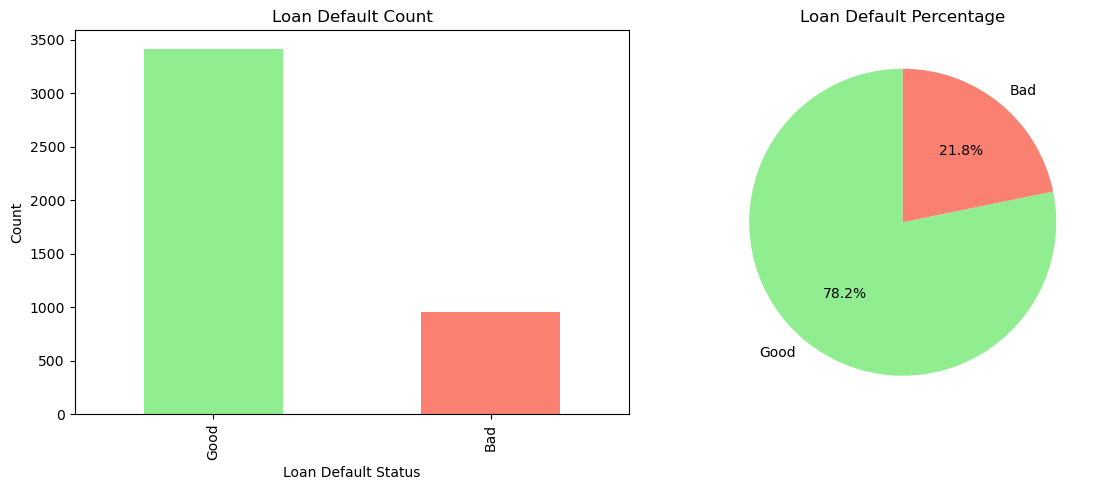

In [98]:
# Bar Chart: Distribution of Loan Defaults

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Bar Chart on the left
final_df['loan_default'].value_counts().plot(
    kind='bar',
    color=['lightgreen', 'salmon'],
    ax=axes[0]
)
axes[0].set_title('Loan Default Count')
axes[0].set_xlabel('Loan Default Status')
axes[0].set_ylabel('Count')

# Pie Chart on the right
final_df['loan_default'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['lightgreen', 'salmon'],
    startangle=90,
    ax=axes[1]
)
axes[1].set_ylabel('')
axes[1].set_title('Loan Default Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

In [99]:
# reassigning the columns
num_cols = final_df.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['loan_default', 'longitude_gps', 'latitude_gps']]

cat_cols = final_df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['bank_name_clients', 'loan_default', 'city', 'state', 'country', 'employment_status_clients']]

target_col = 'loan_default'

# Visualizing the numerical column

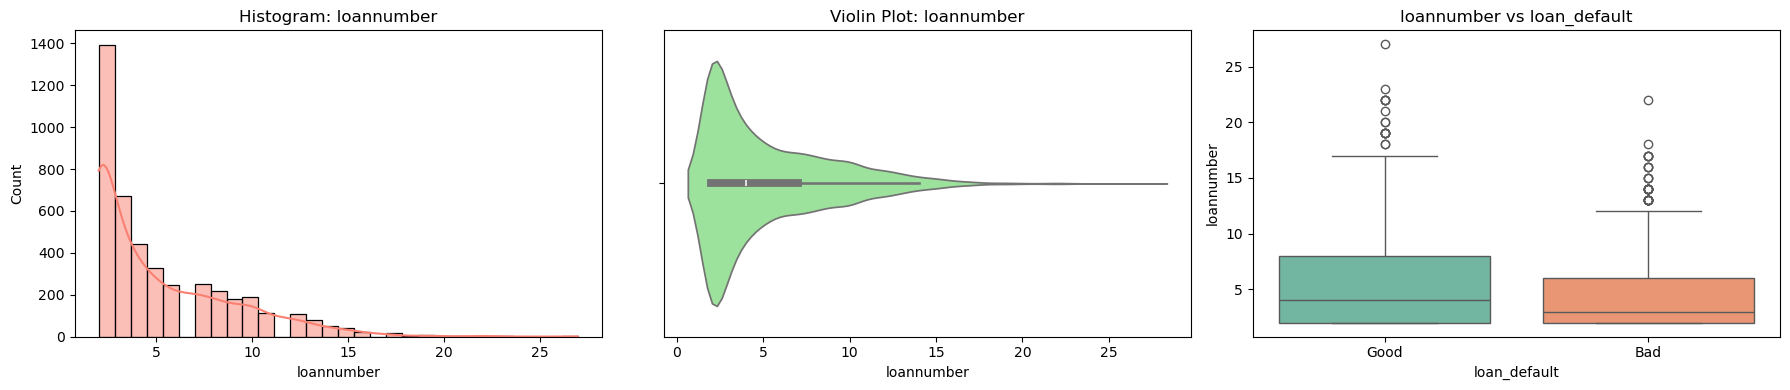

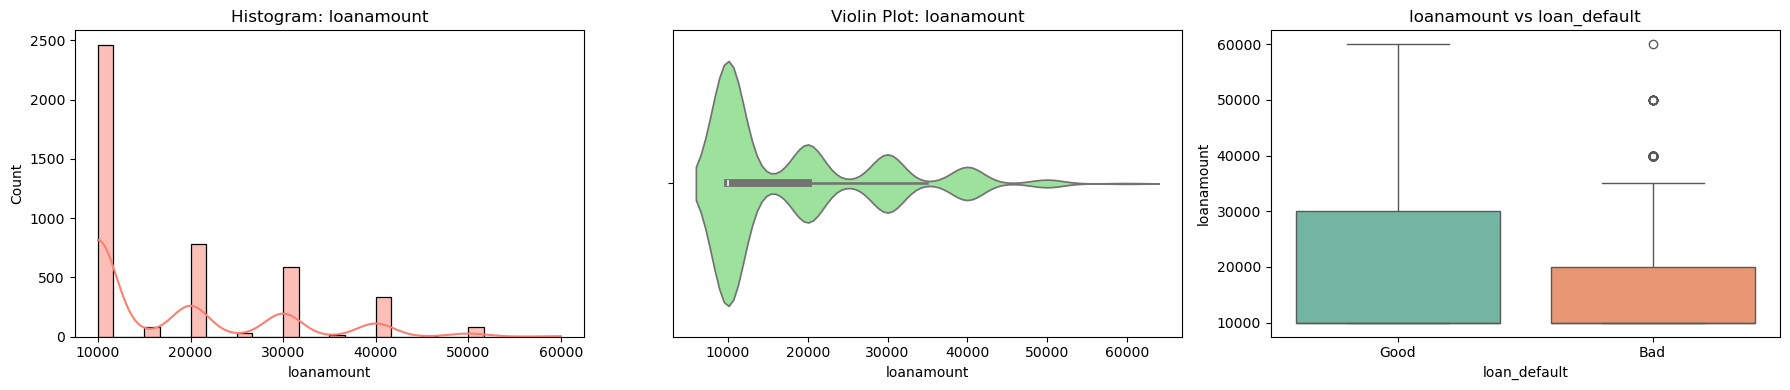

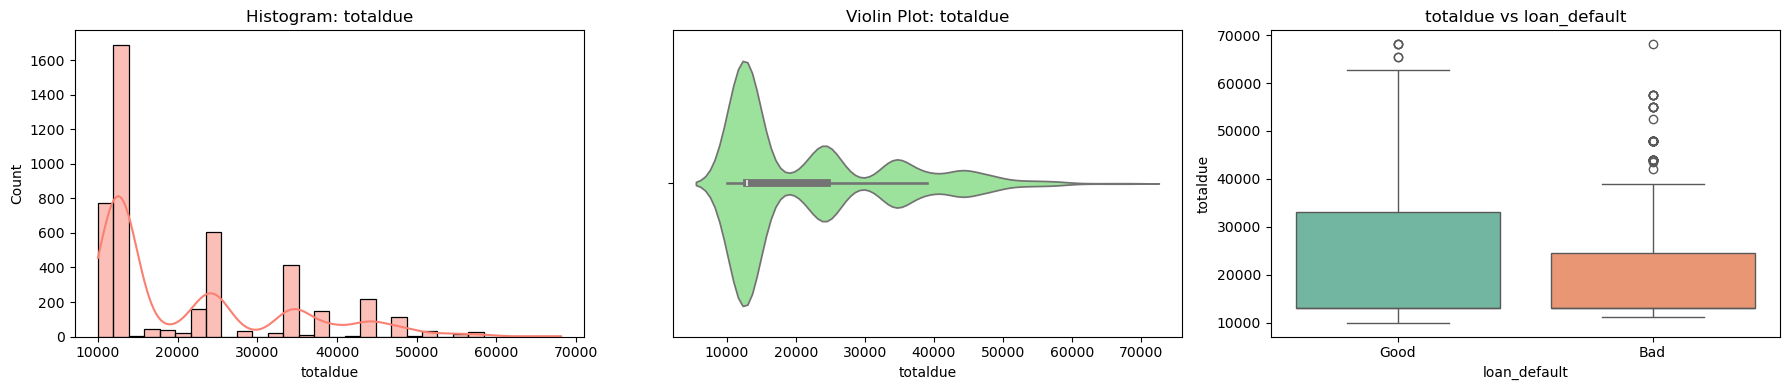

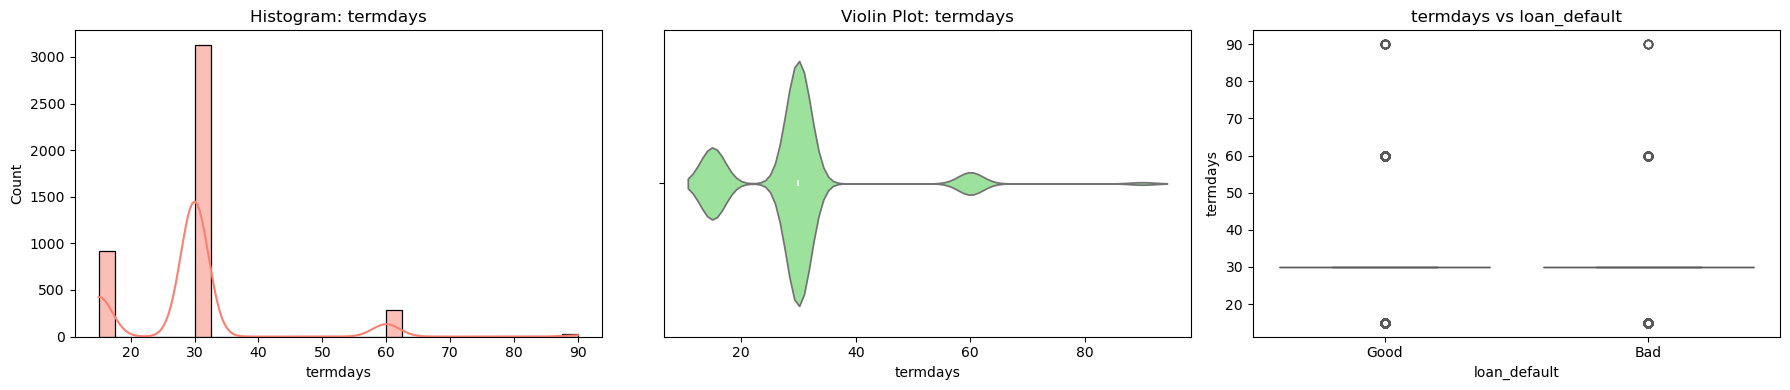

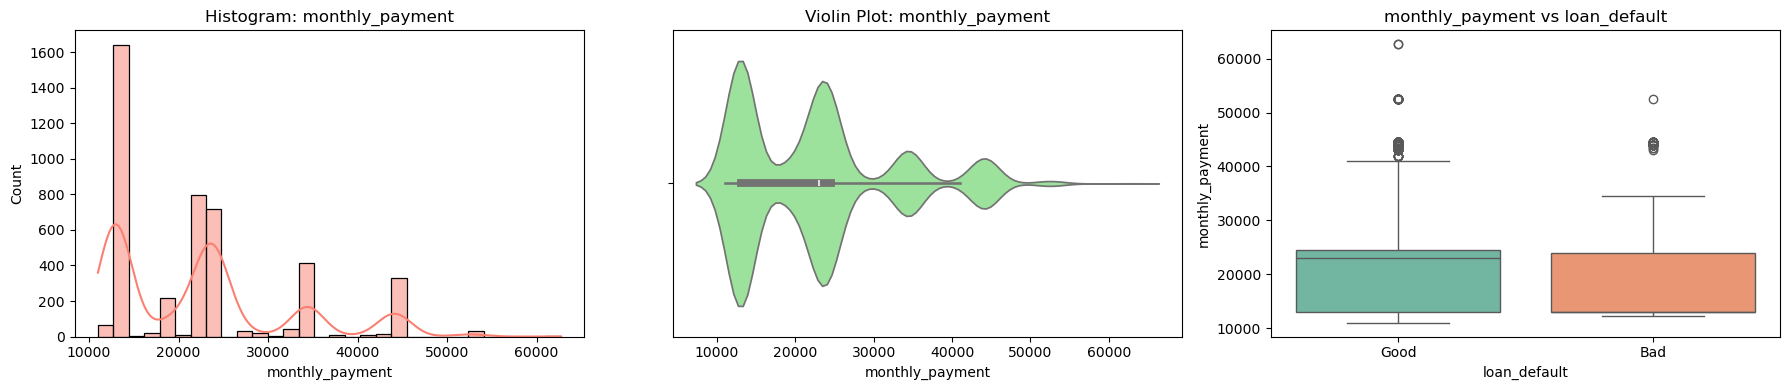

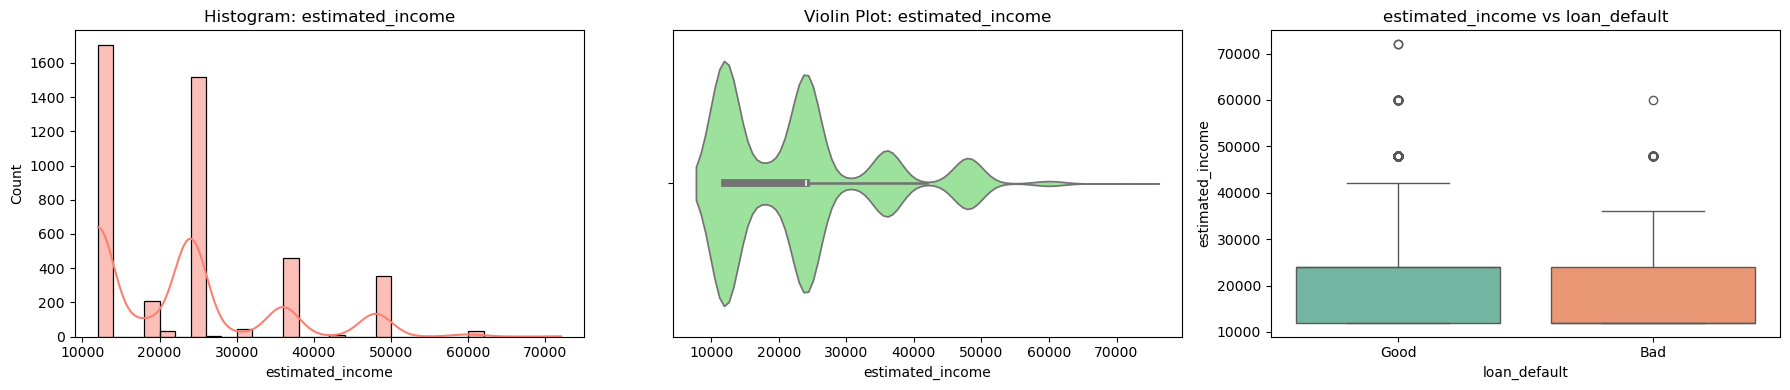

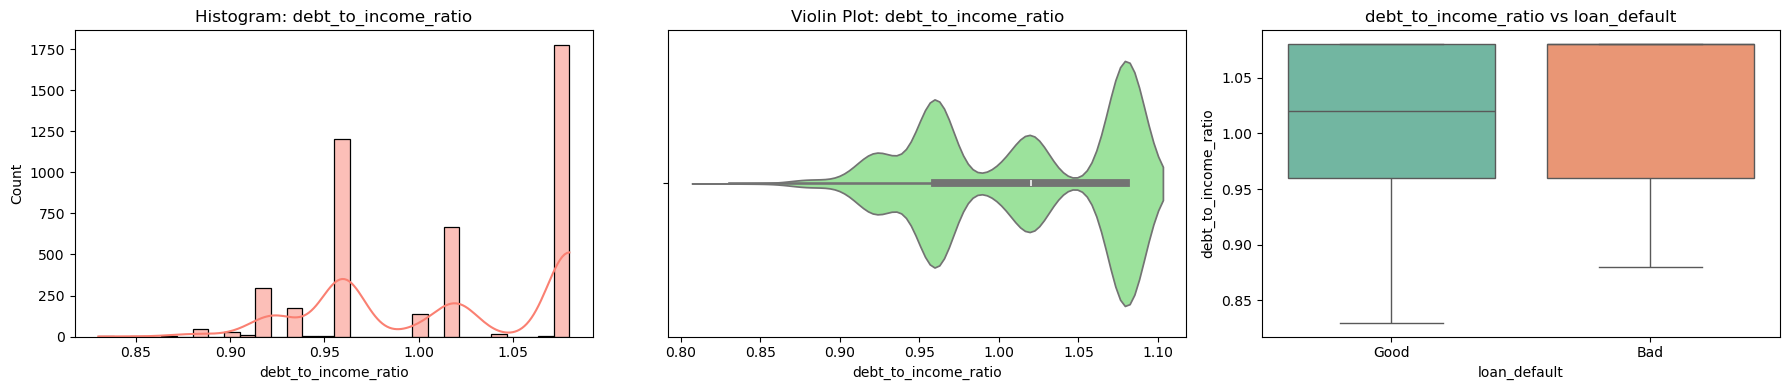

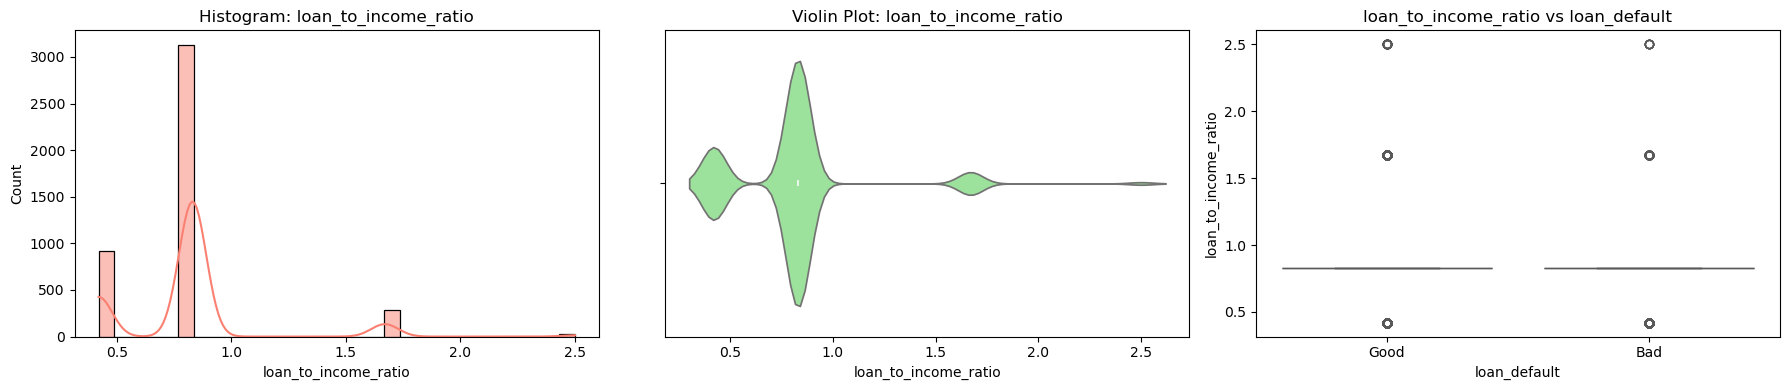

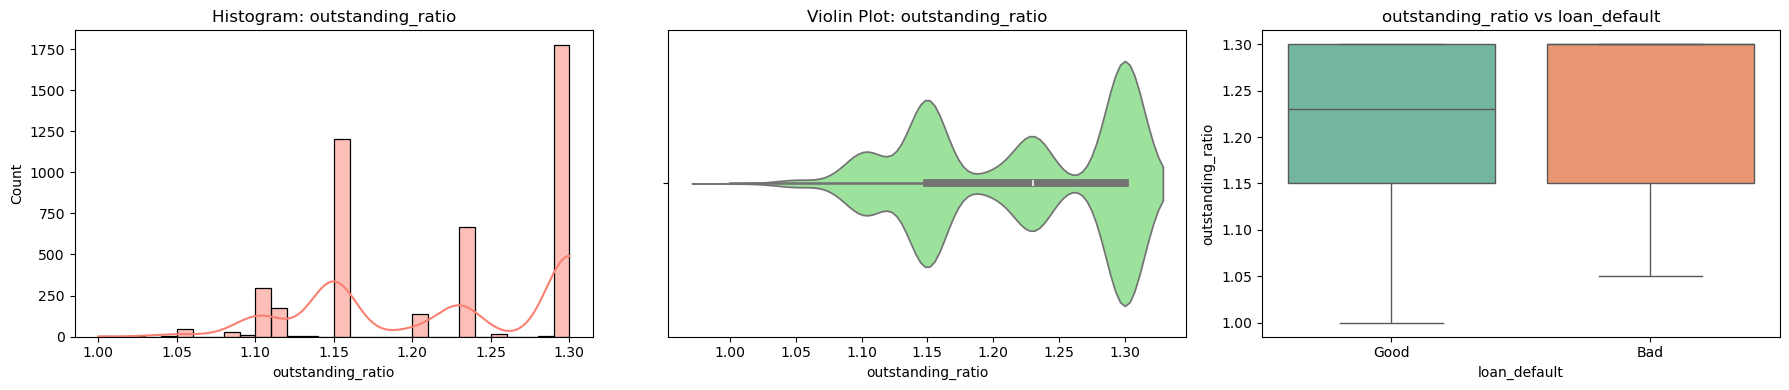

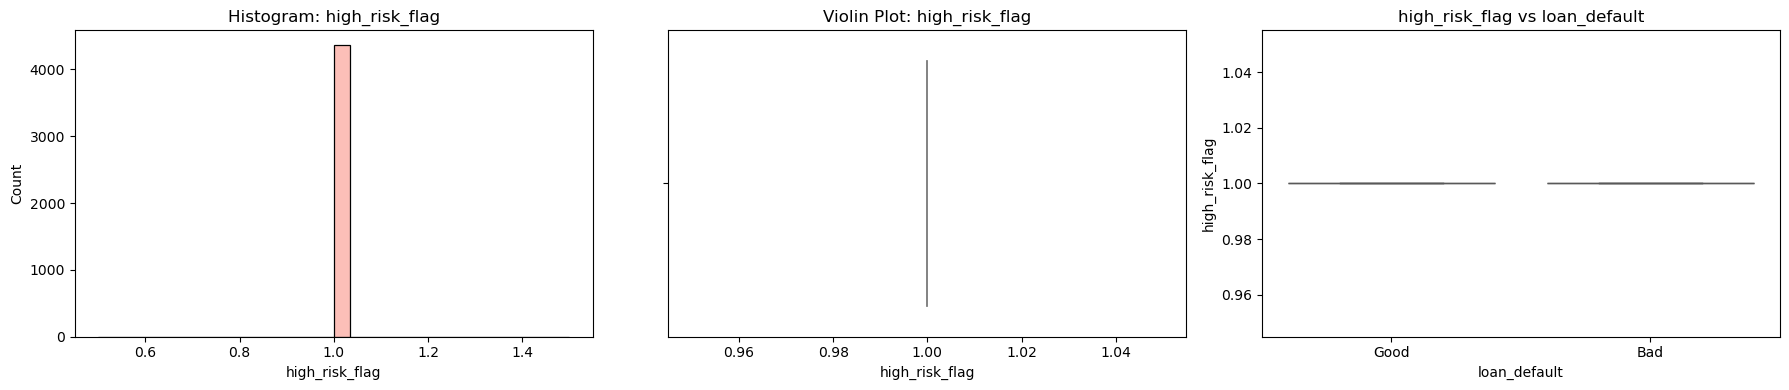

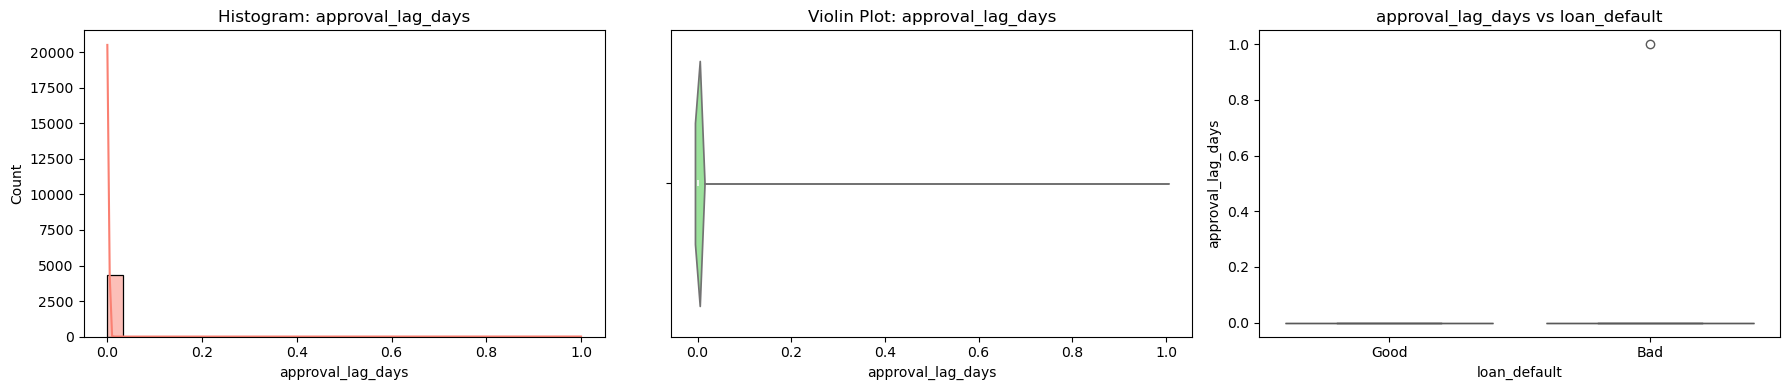

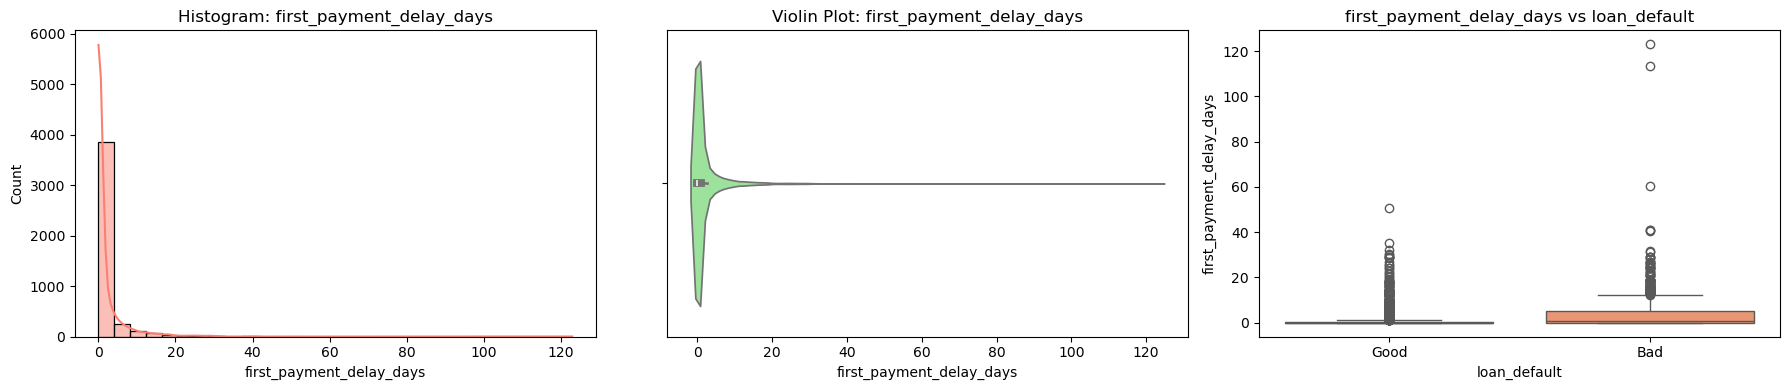

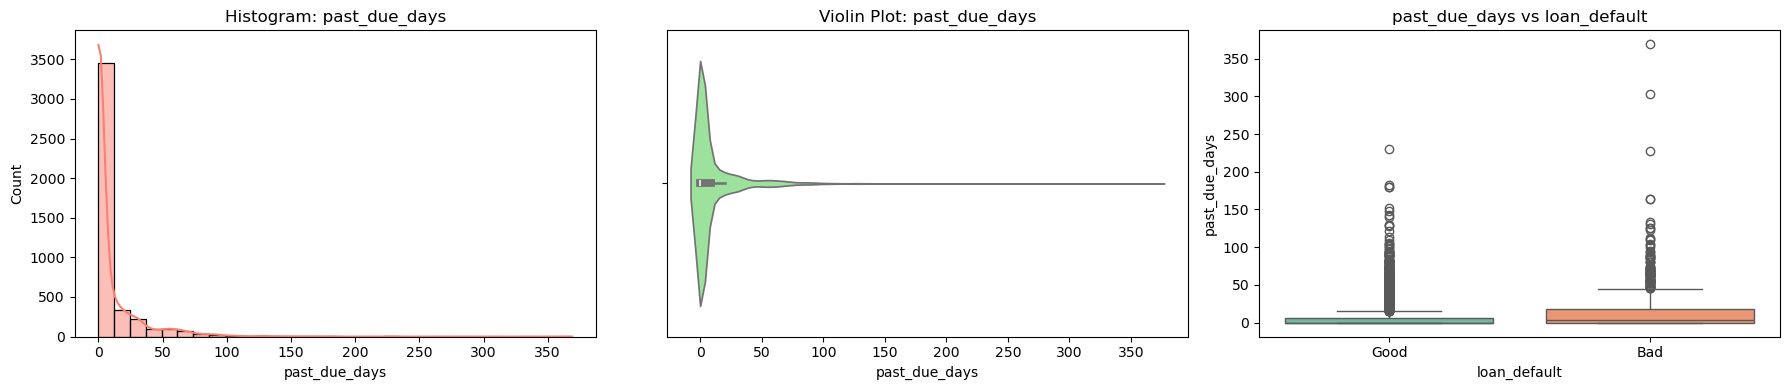

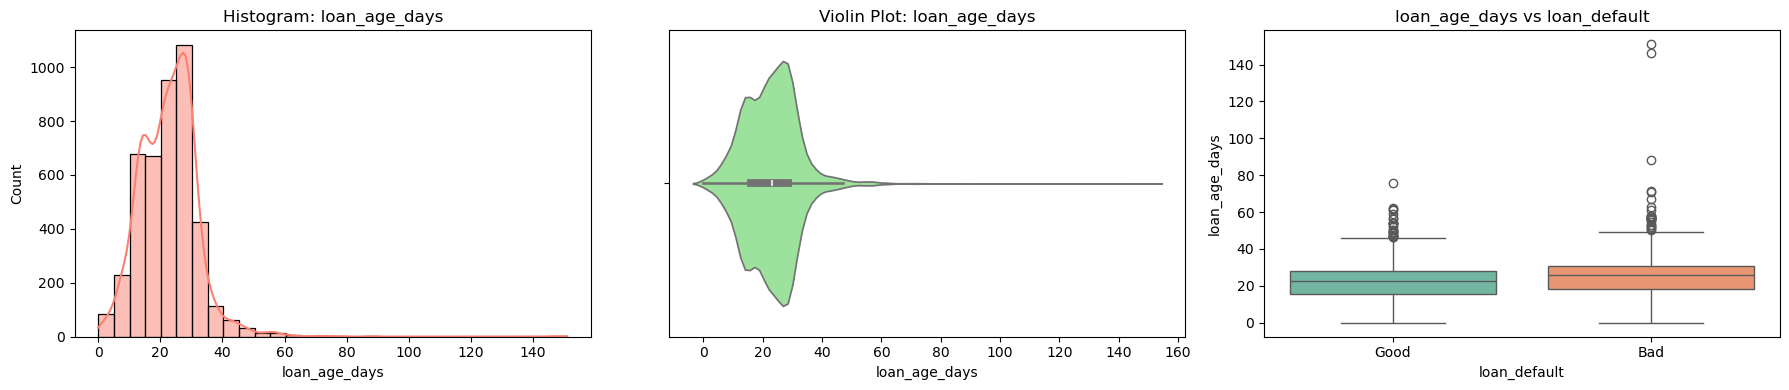

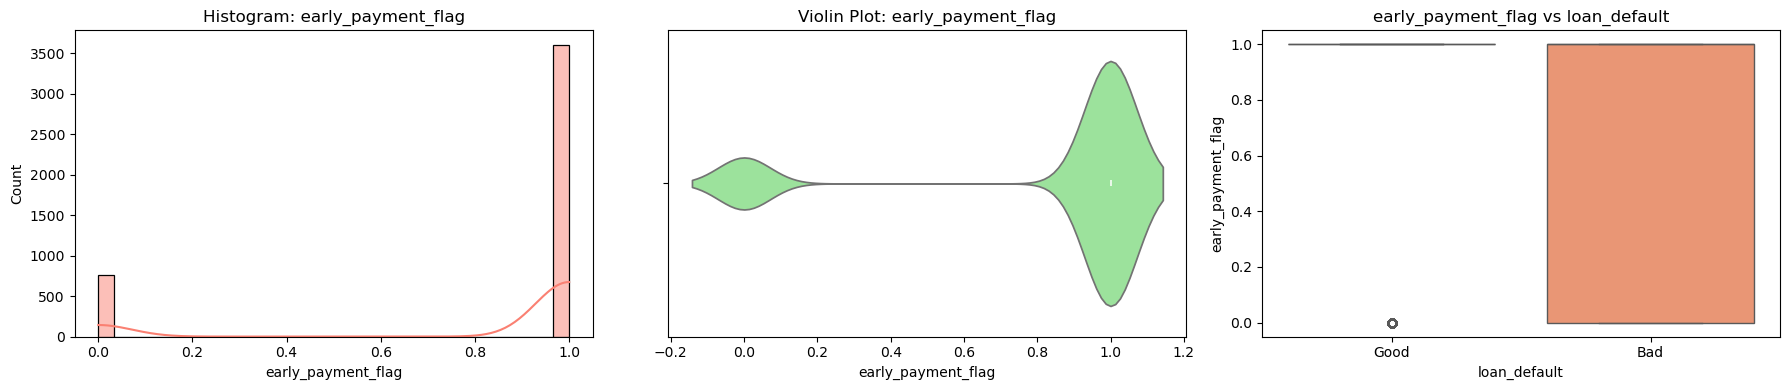

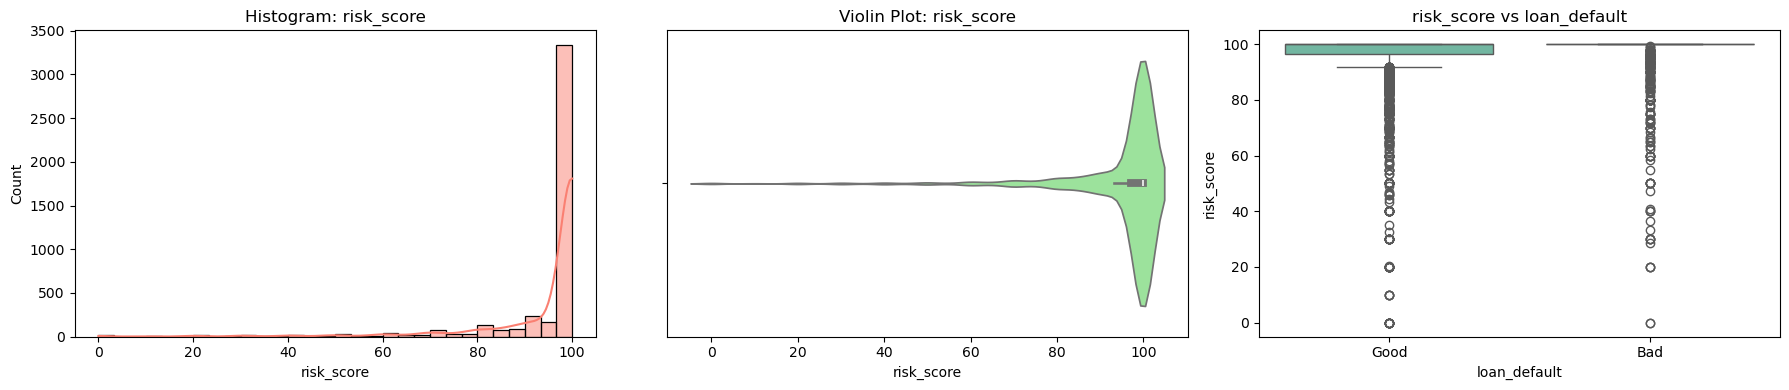

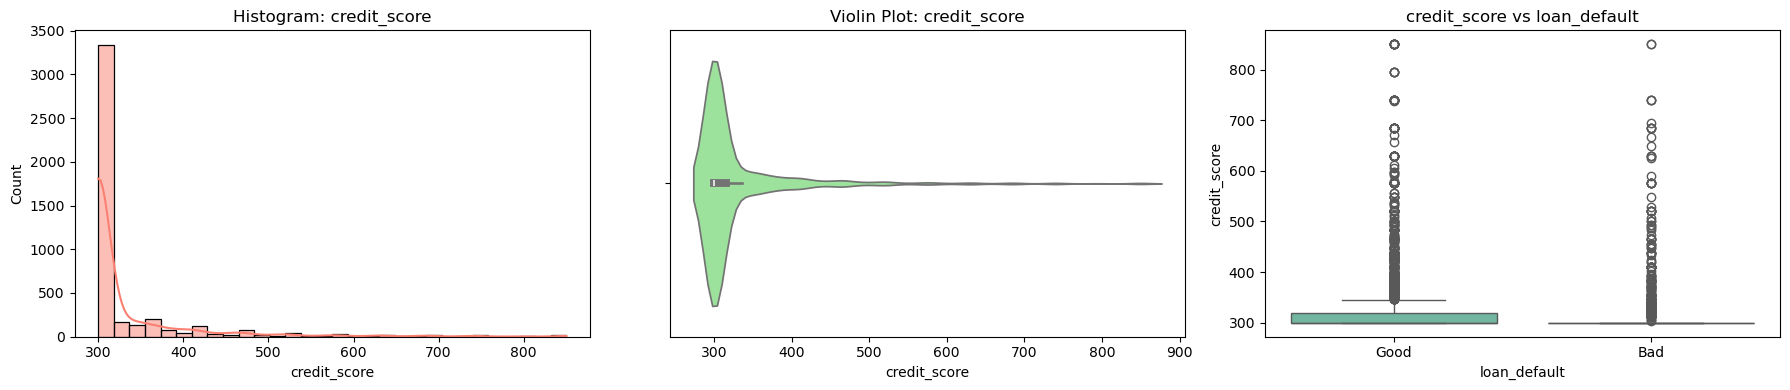

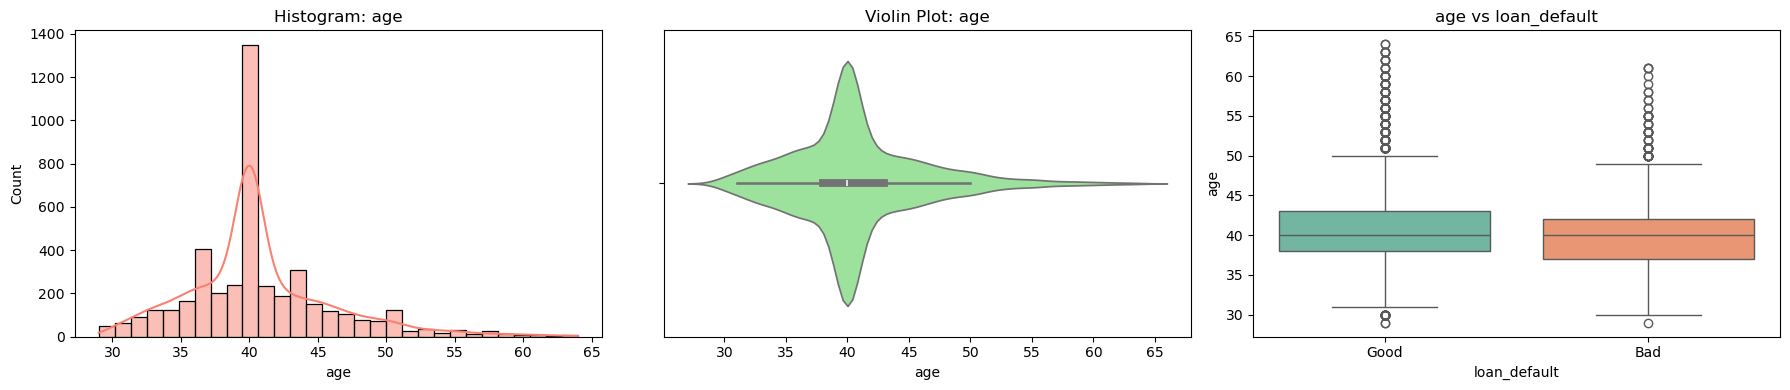

In [100]:
# Loop through numerical columns

for col in num_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram + KDE
    sns.histplot(final_df[col], kde=True, bins=30, color='salmon', ax=axes[0])
    axes[0].set_title(f'Histogram: {col}')

    # Violin Plot
    sns.violinplot(x=final_df[col], color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Violin Plot: {col}')

    # Box Plot (Numerical vs Target)
    sns.boxplot(x=final_df[target_col], y=final_df[col], palette='Set2', ax=axes[2])
    axes[2].set_title(f'{col} vs {target_col}')

    plt.tight_layout()
    plt.show()

# Interpretation and insights

### Loan Behavior and Frequency

| Feature              | Key Stats                 | Interpretation & Insight                                                                                                                          |
| -------------------- | ------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **loannumber**       | mean \~5.17, max 27       | Most customers apply for 2–7 loans, but some very frequent borrowers exist (up to 27). High number of loans may indicate over-borrowing risk.     |
| **loanamount**       | mean \~17,809, max 60,000 | Majority of loans are \~10,000–20,000, with a few high-value outliers. These extreme values may influence model predictions.                      |
| **totaldue**         | mean \~21,257, max 68,100 | Slightly higher than loan amount due to interest/fees. Large max shows some customers have higher obligations, which could increase default risk. |
| **termdays**         | mean \~29.3, max 90       | Most loans are short-term (\~30 days), but some extend to 90 days. Term may influence repayment likelihood.                                       |
| **monthly\_payment** | mean \~22,307, max 62,700 | Payments scale with loan amounts; extreme max indicates some high or multiple loans. Outliers may need capping or transformation.                 |

### Financial Ratios

| Feature                     | Key Stats                 | Interpretation & Insight                                                                                   |
| --------------------------- | ------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **estimated\_income**       | mean \~22,605, max 72,000 | Income distribution is moderate; some high-income borrowers exist, which may reduce default risk.          |
| **debt\_to\_income\_ratio** | mean 1.01, max 1.08       | Most borrowers’ debts roughly equal to or slightly above income. High leverage indicates financial stress. |
| **loan\_to\_income\_ratio** | mean 0.81, max 2.5        | Most loans <1× income; a few extreme cases (>2×) indicate higher default risk.                             |
| **outstanding\_ratio**      | mean 1.22, max 1.3        | Fairly narrow range; reflects proportion of debt outstanding versus expectation.                           |

### Risk & Payment Behavior

| Feature                         | Key Stats          | Interpretation & Insight                                                                         |
| ------------------------------- | ------------------ | ------------------------------------------------------------------------------------------------ |
| **high\_risk\_flag**            | all 1              | Constant value; not informative for modeling.                                                    |
| **approval\_lag\_days**         | mean \~0, max 1    | Almost all loans approved same day; negligible variance.                                         |
| **first\_payment\_delay\_days** | mean 1.7, max 123  | Most customers pay on time, but extreme delays exist. These outliers may predict defaults.       |
| **past\_due\_days**             | mean 9.5, max 369  | Late payments occur; distribution is skewed. Few borrowers contribute most of the late days.     |
| **loan\_age\_days**             | mean 22.7, max 151 | Loans are mostly short-term; longer durations are rare. Short loans dominate repayment behavior. |
| **early\_payment\_flag**        | mean 0.82          | 82% of loans repaid early at least once → strong indicator of good repayment behavior.           |

### Risk and Credit Scores

| Feature           | Key Stats          | Interpretation & Insight                                                                                         |
| ----------------- | ------------------ | ---------------------------------------------------------------------------------------------------------------- |
| **risk\_score**   | mean 94.9, max 100 | Most borrowers are near high-risk end (0–100 scale). Skewed distribution may require normalization for modeling. |
| **credit\_score** | mean 328, max 850  | Most customers at minimum (300), few high scores. Skewed distribution; low creditworthiness dominates.           |

### Demographics

| Feature | Key Stats         | Interpretation & Insight                                                                         |
| ------- | ----------------- | ------------------------------------------------------------------------------------------------ |
| **age** | mean 40.7, max 64 | Majority of borrowers are 36–43 years old. Narrow range; age may have moderate predictive value. |


### Key Modeling Insights

1. **Skewed Distributions / Outliers:**

   * `loanamount`, `totaldue`, `monthly_payment`, `first_payment_delay_days`, `past_due_days`, `credit_score` → consider log transformation or capping.

2. **Constant Features:**

   * `high_risk_flag`, `approval_lag_days` → drop these; they add no predictive value.

3. **Behavioral Features are Strong Predictors:**

   * `first_payment_delay_days`, `past_due_days`, `early_payment_flag`, `loan_age_days` → highly relevant for default prediction.

4. **Financial Stress Indicators:**

   * `debt_to_income_ratio`, `loan_to_income_ratio` → useful for assessing ability to repay.

5. **Short-term Loan Patterns:**

   * Most loans are <30 days; modeling should account for short-term repayment behavior.

# Visualizing categorical columns

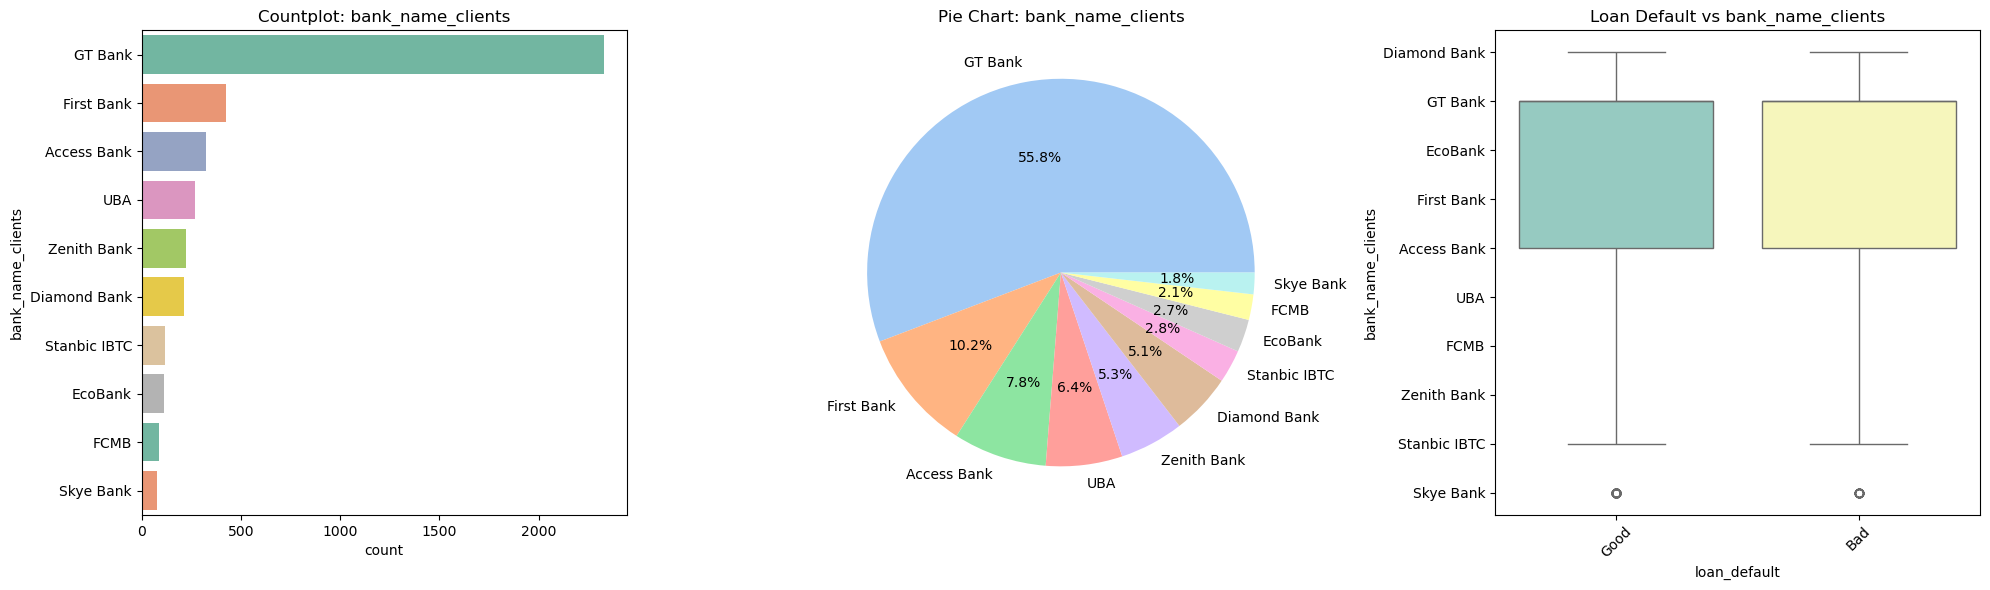

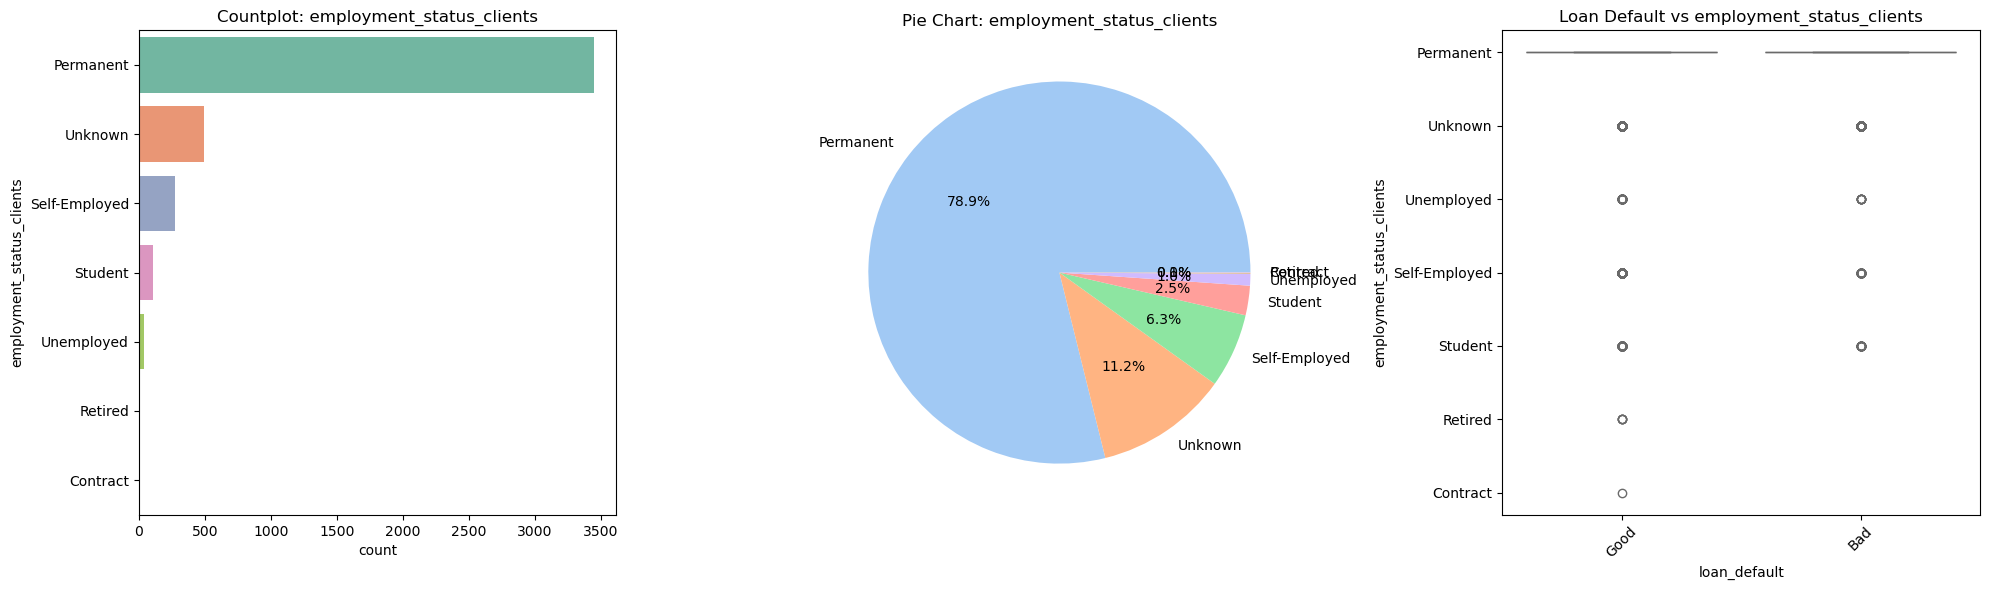

In [101]:
for col in ['bank_name_clients', 'employment_status_clients']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    if col == 'bank_name_clients':
        # Get top 10 banks
        top10_banks = final_df[col].value_counts().nlargest(10).index
        df_plot = final_df[final_df[col].isin(top10_banks)]
    else:
        df_plot = final_df.copy()

    # Countplot
    sns.countplot(y=col, data=df_plot, order=df_plot[col].value_counts().index, palette='Set2', ax=axes[0])
    axes[0].set_title(f'Countplot: {col}')

    # Pie chart
    df_plot[col].value_counts().plot.pie(
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'),
        ax=axes[1]
    )
    axes[1].set_ylabel('')
    axes[1].set_title(f'Pie Chart: {col}')

    # Boxplot of target vs category
    sns.boxplot(x=df_plot['loan_default'], y=df_plot[col], palette='Set3', ax=axes[2])
    axes[2].set_title(f'Loan Default vs {col}')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Interpretation and insight

### Bank Name Clients

| Metric | Value   | Interpretation & Insight              |
| ------ | ------- | ------------------------------------- |
| count  | 4,368   | All records have a bank name.         |
| unique | 18      | Customers use 18 different banks.     |
| top    | GT Bank | Most common bank is GT Bank.          |
| freq   | 2,327   | \~53% of customers bank with GT Bank. |

**Insight:**

* Slightly skewed distribution: more than half of customers are concentrated in one bank.
* The feature is **moderately categorical** with 18 levels.
* For modeling:

  * Consider **grouping smaller banks as “Other”** to reduce cardinality.
  * Can use **one-hot encoding** for major banks, or **target encoding** if appropriate.

### Employment Status Clients

| Metric | Value     | Interpretation & Insight                    |
| ------ | --------- | ------------------------------------------- |
| count  | 4,368     | Complete, no missing values.                |
| unique | 7         | Seven employment types.                     |
| top    | Permanent | Most common status is Permanent employment. |
| freq   | 3,445     | \~79% are permanently employed.             |

**Insight:**

* Highly skewed: majority are Permanent.
* Minority employment types may have fewer samples, which could reduce predictive signal.
* For modeling:

  * Consider **grouping rare employment types into “Other”**.
  * Can use **one-hot or ordinal encoding** depending on model type.

### Overall Takeaways

1. Both features are **categorical with skewed distributions**.
2. **GT Bank** and **Permanent employment** dominate, so predictive contribution may be limited unless rare categories are grouped intelligently.
3. **Encoding strategies**:

   * One-hot for main categories, rest grouped.
   * Target encoding if using tree-based models.

# Visualization of other categorical columns

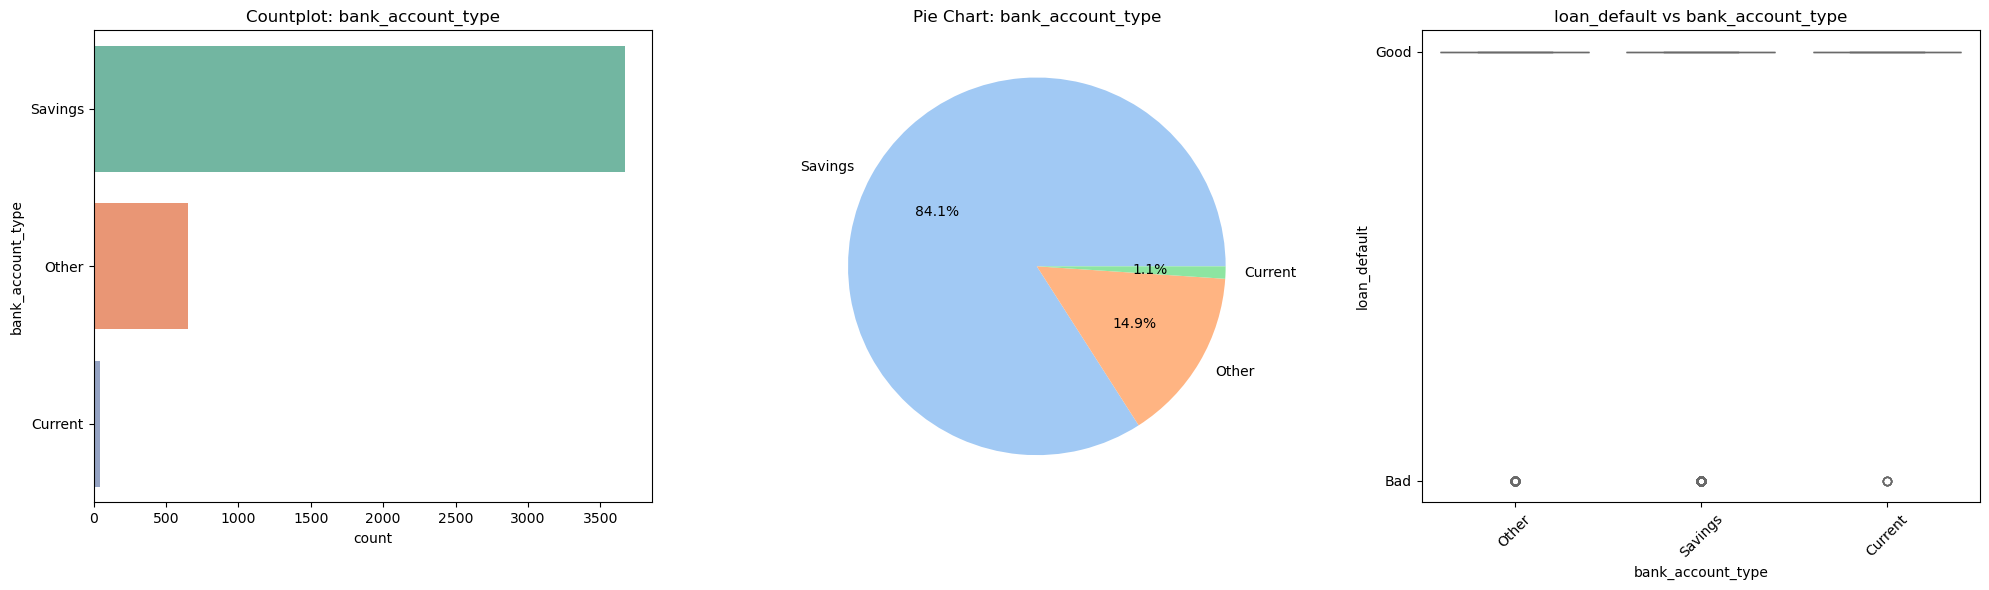

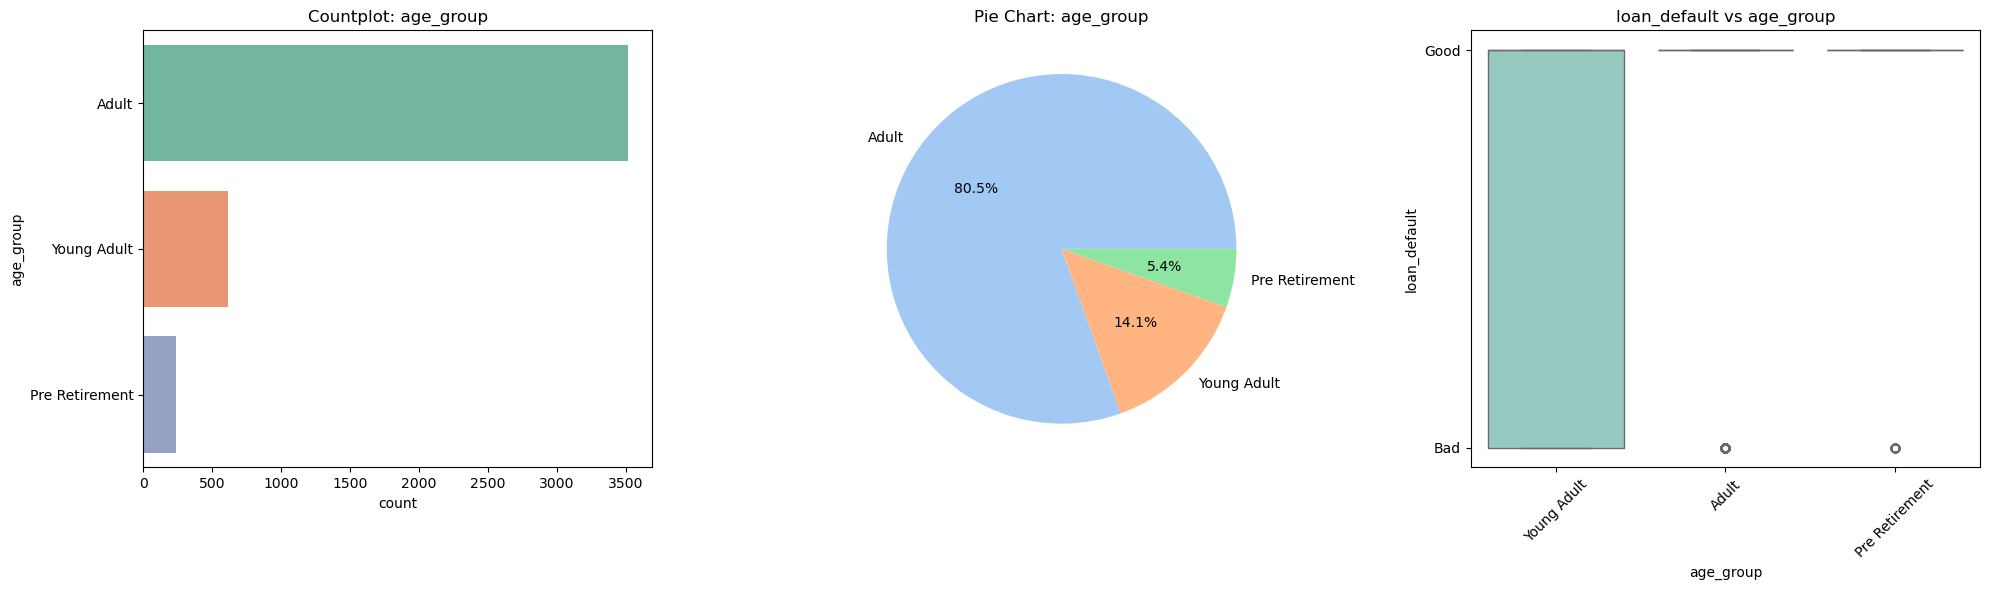

In [102]:
# Remove 'customerid' from cat_cols if it exists
cat_cols = [col for col in cat_cols if col.lower() != "customerid"]

for col in cat_cols:  
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Countplot
    sns.countplot(y=col, data=final_df, order=final_df[col].value_counts().index, palette='Set2', ax=axes[0])
    axes[0].set_title(f'Countplot: {col}')

    # Pie chart
    final_df[col].value_counts().plot.pie(
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'),
        ax=axes[1]
    )
    axes[1].set_ylabel('')
    axes[1].set_title(f'Pie Chart: {col}')

    # Target vs Categorical (Boxplot of target grouped by col)
    sns.boxplot(x=col, y=final_df[target_col], data=final_df, palette='Set3', ax=axes[2])
    axes[2].set_title(f'{target_col} vs {col}')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Interpretation and insight

### Bank Account Type

| Metric | Value   | Interpretation & Insight                                  |
| ------ | ------- | --------------------------------------------------------- |
| count  | 4,368   | All records have a bank account type (no missing values). |
| unique | 3       | There are 3 different account types.                      |
| top    | Savings | Most common account type is “Savings”.                    |
| freq   | 3,672   | 84% of customers have a Savings account.                  |

**Insight:**

* Majority of customers use Savings accounts, so this feature is **highly skewed**.
* May have **limited predictive power** for loan default on its own.
* Could be grouped into “Savings vs Others” for simplicity.

### Age Group

| Metric | Value | Interpretation & Insight                                       |
| ------ | ----- | -------------------------------------------------------------- |
| count  | 4,368 | No missing values.                                             |
| unique | 3     | Age is categorized into 3 groups (e.g., Young, Adult, Senior). |
| top    | Adult | Most customers (3,516) fall in the Adult category (\~80%).     |
| freq   | 3,516 | Adults dominate; Young and Senior are minorities.              |

**Insight:**

* The dataset is **dominated by Adult borrowers**, which may reduce variability for predictive modeling.
* If predictive signal is weak, consider **combining age\_group with numeric age** for more granularity.

### Overall Takeaways

1. Both features are **categorical and skewed**, with one category dominating.
2. For modeling:

   * Use **one-hot encoding** or **binary grouping** (majority vs minority).
   * Be cautious: features with little variability may have **low predictive power**.

# Sample grouping by state

In [103]:
# Map loan_default to numeric: Good=0 (no default), Bad=1 (default)
final_df['loan_default_numeric'] = final_df['loan_default'].map({'Good': 0, 'Bad': 1})

# Group by state using the numeric column
state_grouped = final_df.groupby('state').agg({
    'loan_default_numeric': ['count', 'sum', 'mean'],   # Total borrowers, defaults, default rate
    'loanamount': 'mean',                               # Average loan amount
    'monthly_payment': 'mean',                          # Average monthly payment
    'high_risk_flag': 'sum'                             # Number of high-risk borrowers
})

# Rename columns
state_grouped.columns = [
    'total_borrowers', 'total_defaults', 'default_rate', 
    'avg_loan_amount', 'avg_monthly_payment', 'high_risk_count'
]

# Reset index
state_grouped = state_grouped.reset_index()

# Display tabulated summary
print("Summary Table: Loan Defaults by State")
display(state_grouped.sort_values(by='default_rate', ascending=False))

Summary Table: Loan Defaults by State


state  total_borrowers  total_defaults  default_rate  \
35                    Zamfara                1               1      1.000000   
10                     Ebonyi                4               2      0.500000   
19                       Kano               22               9      0.409091   
22                       Kogi               22               8      0.363636   
15                      Gombe                3               1      0.333333   
20                    Katsina                6               2      0.333333   
8                 Cross River               27               9      0.333333   
2                   Akwa Ibom               27               8      0.296296   
28                       Ondo               72              21      0.291667   
16                        Imo               14               4      0.285714   
11                        Edo               57              15      0.263158   
29                       Osun               74              19      0.256757   
1                     Adamawa                8               2      0.250000   
18                     Kaduna               60              15      0.250000   
12                      Ekiti               28               7      0.250000   
5                     Bayelsa               44              11      0.250000   
30                        Oyo              266              66      0.248120   
3                     Anambra               29               7      0.241379   
23                      Kwara              101              24      0.237624   
32                     Rivers              132              31      0.234848   
13                      Enugu               27               6      0.222222   
14  Federal Capital Territory              300              63      0.210000   
24                      Lagos             2532             528      0.208531   
25                   Nasarawa               24               5      0.208333   
27                       Ogun              306              62      0.202614   
33                     Sokoto                5               1      0.200000   
31                    Plateau               23               4      0.173913   
9                       Delta               81              13      0.160494   
26                      Niger               19               3      0.157895   
6                       Benue               22               3      0.136364   
0                        Abia               19               2      0.105263   
21                      Kebbi                3               0      0.000000   
4                      Bauchi                4               0      0.000000   
7                       Borno                4               0      0.000000   
17                     Jigawa                1               0      0.000000   
34                     Taraba                1               0      0.000000   

    avg_loan_amount  avg_monthly_payment  high_risk_count  
35     15000.000000         18375.000000                1  
10     20000.000000         20000.000000                4  
19     21363.636364         22727.272727               22  
22     15000.000000         21636.363636               22  
15     20000.000000         31166.666667                3  
20     11666.666667         18250.000000                6  
8      15370.370370         20148.148148               27  
2      16481.481481         22907.407407               27  
28     18541.666667         21973.263889               72  
16     25000.000000         26482.142857               14  
11     14912.280702         20973.684211               57  
29     16756.756757         21296.171216               74  
1      25000.000000         28812.500000                8  
18     19166.666667         21781.111167               60  
12     16428.571429         22638.392857               28  
5      17272.727273         22468.747727               44  
30     18778.195489         23471.146654   

# Interpretation and Insights

### Key Observations:

**Default Rates Vary Significantly by State**

   * **Highest default rates:** Zamfara (100%), Ebonyi (50%), Kano (41%), Kogi (36%)
     These states have very small sample sizes (1–22 borrowers), so extreme default rates are heavily influenced by a few loans.
   * **Moderate default rates:** Oyo (24.8%), Lagos (20.8%), Federal Capital Territory (21%)
     These states have larger sample sizes, so default rates are more representative.
   * **Lowest default rates:** Kebbi, Bauchi, Borno, Jigawa, Taraba (0%)
     Again, small sample sizes here might hide risk; more data is needed.

**Borrower Concentration**

   * Lagos dominates with **2,532 borrowers**, contributing heavily to overall portfolio risk.
   * Other high-volume states include Oyo (266), Federal Capital Territory (300), and Ogun (306).
   * Small states like Zamfara and Taraba have minimal borrowers, so extreme percentages may not reflect real risk.

**Average Loan Amounts**

   * Loan amounts range roughly from 10,000 to 27,500.
   * Some high-default states like Kano (21,364) and Enugu (21,852) also have above-average loan amounts. Larger loans may correlate with higher defaults.

**Average Monthly Payments**

   * States with high defaults often have higher monthly payments (e.g., Jigawa: 44,500, Sokoto: 29,900). This may indicate borrower strain and potential cash flow issues.

**High-Risk Borrowers**

   * `high_risk_count` generally tracks total borrowers, indicating that many borrowers flagged as high risk also appear in the default counts.

### Insights for Decision-Making:

* **Small sample caution:** States with very few borrowers and extreme default rates (like Zamfara, Ebonyi, Jigawa) should be interpreted cautiously. Consider aggregating or monitoring closely rather than making lending decisions based solely on these numbers.
* **Focus on high-volume states:** Lagos, Oyo, Federal Capital Territory, Ogun — these states contribute the majority of borrowers and defaults, so targeted risk management here could significantly reduce portfolio losses.
* **Loan size and payment strain:** High loan amounts and high monthly payments appear correlated with defaults in some regions, suggesting a need to review affordability and debt-to-income measures.
* **Potential for geospatial risk modeling:** Mapping defaults and high-risk borrowers can highlight regional clusters and support risk-based lending strategies.

# Default Rate by State

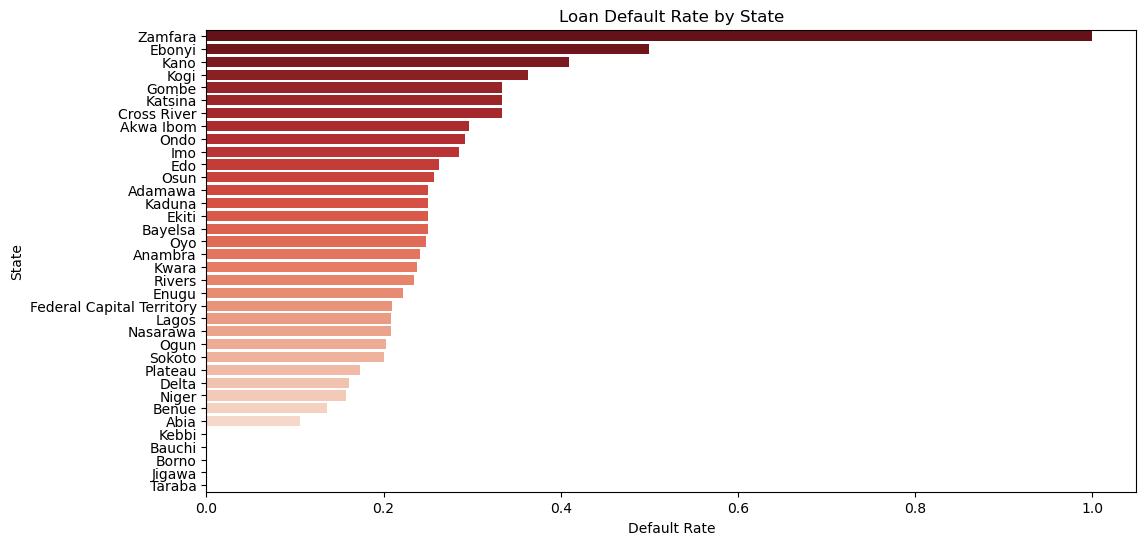

Summary for: state


count unique    top  freq
state  4368     36  Lagos  2532

In [104]:
# Bar chart: Default Rate by State
plt.figure(figsize=(12,6))
sns.barplot(
    x='default_rate', 
    y='state', 
    data=state_grouped.sort_values('default_rate', ascending=False),
    palette='Reds_r'
)
plt.title('Loan Default Rate by State')
plt.xlabel('Default Rate')
plt.ylabel('State')
plt.show()

# Display summary table for 'state'
summary_table = pd.DataFrame(final_df['state'].describe()).T
print("Summary for: state")
display(summary_table)

# Interpretation and Insights

* There are **4,368 loan records** in total.
* There are **36 unique states** represented in the dataset.
* The most common state is **Lagos**, with **2,532 loans**, which is **over half of the total dataset**.

**Insights:**

**Data Concentration:** Lagos dominates the dataset, which could bias the model if state is used as a feature. Most defaults and behaviors might reflect Lagos trends rather than nationwide trends.
**Feature Consideration:** State is categorical, and because of this skew, i might consider:

   * Encode it carefully (e.g., one-hot encoding).
   * Possibly group smaller states into an “Other” category to reduce sparsity.

# Choropleth Map: Loan default and high risk borrowers by State (Plotly)

In [105]:
import json

with open("nigeria_state.geojson", "r", encoding="utf-8") as f:
    geojson = json.load(f)

print("Loaded GeoJSON keys:", geojson.keys())

Loaded GeoJSON keys: dict_keys(['type', 'features'])


In [106]:
# Check unique state names in your GeoJSON
state_names = sorted({f["properties"]["name"] for f in geojson["features"]})
print(state_names)

['Abia', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Ekiti', 'Enugu', 'Federal Capital Territory', 'Gombe', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Nassarawa', 'Niger', 'Ogun', 'Ondo', 'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara']


In [107]:
# importing neccesry libraries
import plotly.express as px
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time

# Automatic geocoding for Nigerian states
geolocator = Nominatim(user_agent="loan_default_map")
states = state_grouped['state'].unique()
coords = []

for state in states:
    try:
        location = geolocator.geocode(f"{state}, Nigeria")
        if location:
            coords.append({"state": state, "lat": location.latitude, "lon": location.longitude})
        else:
            coords.append({"state": state, "lat": None, "lon": None})
    except:
        coords.append({"state": state, "lat": None, "lon": None})
    time.sleep(1)  # avoid request throttling

coords_df = pd.DataFrame(coords)
state_grouped = state_grouped.merge(coords_df, on="state", how="left")

# Optional: save coordinates to CSV for future reuse
coords_df.to_csv("state_coordinates.csv", index=False)

# Creating choropleth
fig = px.choropleth(
    state_grouped,
    geojson=geojson,
    locations="state",
    featureidkey="properties.name",
    color="default_rate",
    hover_name="state",
    hover_data=["total_borrowers", "total_defaults", "avg_loan_amount", "high_risk_count"],
    color_continuous_scale="Reds",
    title="Loan Default Rate by Nigerian State"
)

# Adding bubble layer 
fig.add_trace(go.Scattergeo(
    lon=state_grouped["lon"],
    lat=state_grouped["lat"],
    text=state_grouped["state"] + "<br>High Risk: " + state_grouped["high_risk_count"].astype(str),
    marker=dict(
        size=state_grouped["high_risk_count"] / 50,  # adjust scaling factor
        color="black",
        opacity=0.7,
        line=dict(width=0.5, color="white")
    ),
    hoverinfo="text"
))

# Map layout
fig.update_geos(
    fitbounds="locations",
    visible=False,
    showcountries=False,
    showland=True,
    landcolor="lightgray"
)

fig.update_layout(
    width=1000,
    height=800,
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show()

# Interpretation and Insights:

### Default Rate Analysis

**Highest Risk States:**
  * **Zamfara (100%)**, **Ebonyi (50%)**, **Kano (41%)**, **Kogi (36%)**.
  * These states have very few borrowers, but defaults are high relative to total borrowers. Small sample sizes exaggerate percentages, so caution is needed in interpretation.

**Moderate Risk States:**

  * **Oyo (24.8%)**, **Lagos (20.8%)**, **FCT (21%)**, **Ogun (20%)**.
  * These have larger borrower bases, so defaults are significant and represent meaningful regional risk.

**Lowest Risk States:**

  * **Kebbi, Bauchi, Borno, Jigawa, Taraba** show 0% default rate—either very few loans were issued, or risk is genuinely low.


### Borrower Volume**

**High Borrower States:**

  * **Lagos (2532)** and **Oyo (266)** dominate the portfolio.
  * Even though their default rates are moderate (\~21–25%), their **absolute number of defaults is very high** (Lagos = 528 defaults, Oyo = 66), meaning these regions contribute heavily to total portfolio risk.

**Low Borrower States:**

  * Many states like Zamfara, Jigawa, and Taraba have very few borrowers. Defaults appear extreme as percentages but represent **low absolute impact**.


### Loan and Payment Characteristics

* **Average Loan Amounts:**

  * States like **Imo (25,000)**, **Enugu (21,852)**, and **Kano (21,364)** have higher average loan sizes, increasing financial exposure per borrower.
  * Some low-default states (Bauchi, Jigawa) have smaller borrower counts and variable loan amounts, so their zero defaults may not indicate lower risk under scale.
* **Average Monthly Payment:**

  * Correlates with loan size; higher monthly obligations in high-default states (e.g., Zamfara, Kano, Imo) indicate potential cash flow stress among borrowers.* **High-Risk Count:**

  * Generally mirrors total borrowers, e.g., **Lagos (2532)**, **Oyo (266)**.
  * Small states like **Zamfara (1)** or **Ebonyi (4)** show the same pattern but with much lower overall impact.


### Key Insights

1. **High Default Clusters:**

   * Northern and some mid-western states (Zamfara, Kano, Kogi) have elevated default rates relative to borrower count—potential hotspots for risk-based monitoring.
2. **Volume vs. Risk Tradeoff:**

   * Lagos and Oyo dominate total defaults due to sheer borrower numbers, even though default **rates** are lower than some small states. These states are crucial for overall portfolio health.
3. **Loan Size Sensitivity:**

   * High average loan amounts combined with high default rates (Kano, Imo) increase financial exposure—targeted credit controls may be warranted.
4. **Low-Activity States:**

   * Zero-default states (Kebbi, Bauchi, Borno, Jigawa, Taraba) may appear low-risk but need more borrower volume to assess true risk.

### Recommendations

* **Monitoring & Strategy:**

  * Focus on high-default regions (Zamfara, Kano, Kogi) for tighter risk controls, even if borrower count is low.
  * Prioritize portfolio management in high-volume states (Lagos, Oyo) to reduce absolute defaults.
* **Regional Risk Scoring:**

  * Incorporate **state-level default rates** and **loan sizes** into predictive modeling for geospatial risk analysis.
* **Portfolio Diversification:**

  * Avoid over-concentration in high-risk clusters; consider adjusting loan approval criteria by state.

In [108]:
final_df.columns

Index(['customerid', 'loannumber', 'loanamount', 'totaldue', 'termdays',
       'loan_default', 'monthly_payment', 'estimated_income',
       'debt_to_income_ratio', 'loan_to_income_ratio', 'outstanding_ratio',
       'high_risk_flag', 'approval_lag_days', 'first_payment_delay_days',
       'past_due_days', 'loan_age_days', 'early_payment_flag', 'risk_score',
       'credit_score', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients', 'age', 'age_group',
       'city', 'state', 'country', 'loan_default_numeric'],
      dtype='object')

In [109]:
# dropping irrelevant columns after visualization
columns_to_drop = ['customerid', 'longitude_gps', 'latitude_gps', 'age_group', 'city', 'state', 'country', 'loan_default_numeric']

final_df = final_df.drop(columns=columns_to_drop, axis=1, errors='ignore')

In [110]:
# rechacking the top 2 rows
final_df.head(2)

loannumber  loanamount  totaldue  termdays loan_default  monthly_payment  \
0          12     30000.0   34500.0        30         Good          34500.0   
1           2     15000.0   17250.0        30         Good          17250.0   

   estimated_income  debt_to_income_ratio  loan_to_income_ratio  \
0           36000.0                  0.96                  0.83   
1           18000.0                  0.96                  0.83   

   outstanding_ratio  ...  first_payment_delay_days  past_due_days  \
0               1.15  ...                      6.82           75.0   
1               1.15  ...                      0.00            0.0   

   loan_age_days  early_payment_flag  risk_score  credit_score  \
0          29.45                 1.0       87.27         370.0   
1          23.00                 1.0      100.00         300.0   

   bank_account_type  bank_name_clients employment_status_clients   age  
0              Other       Diamond Bank                 Permanent  53.0  
1            Savings            GT Bank                 Permanent  40.0  

[2 rows x 22 columns]

# Correlation Matrix

A Correlation Heatmap is used show how strongly numerical variables are related.

It will help to:
 - Find patterns – spot variables that move together.
 - Detect redundancy – identify features that are too similar (multicollinearity).
 - Guide feature selection – keep useful predictors, drop duplicates.
 - Check data quality – unusual correlations may signal errors.
 - Quick visual insight – colors make patterns obvious.

In [111]:
# rechecking columns
final_df.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'loan_default',
       'monthly_payment', 'estimated_income', 'debt_to_income_ratio',
       'loan_to_income_ratio', 'outstanding_ratio', 'high_risk_flag',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'risk_score', 'credit_score',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age'],
      dtype='object')

In [112]:
num_cols = ['loannumber', 'loanamount', 'totaldue', 'termdays',
       'monthly_payment', 'estimated_income', 'debt_to_income_ratio',
       'loan_to_income_ratio', 'outstanding_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'risk_score', 'credit_score',
       'age']

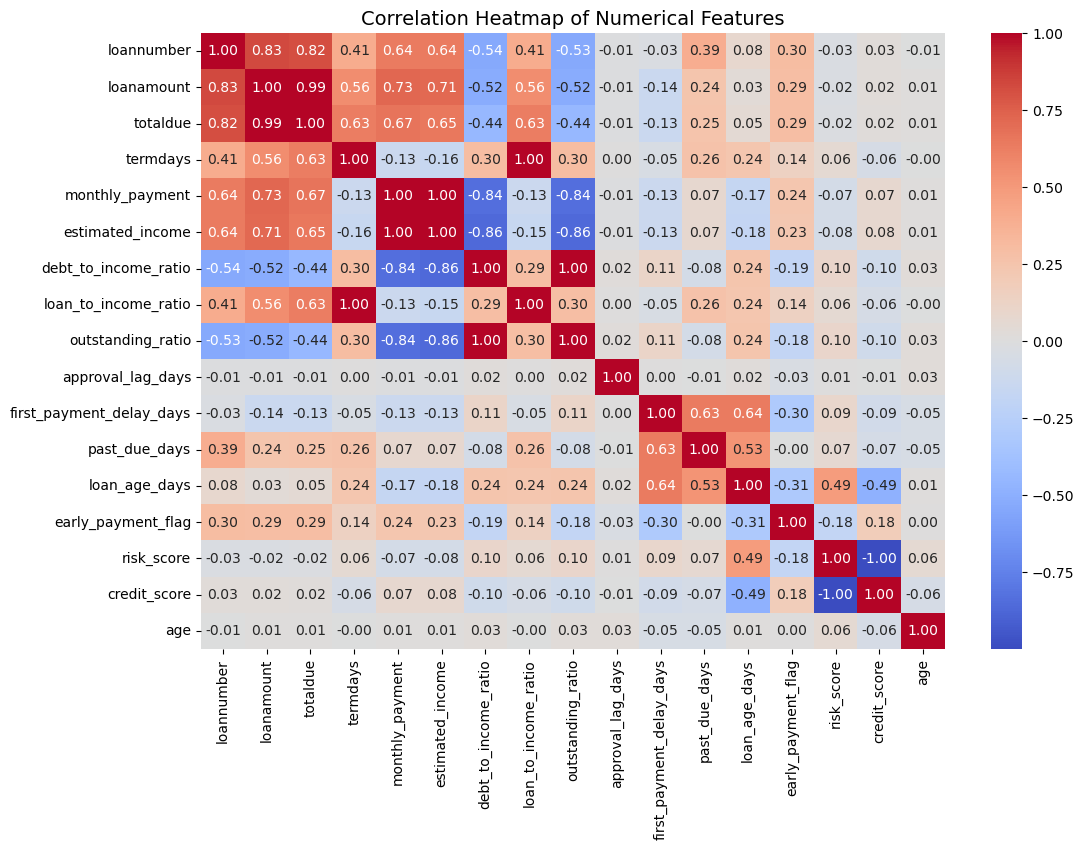

In [113]:
# Correlation matrix of numerical features

# Computing correlation matrix
corr_matrix = final_df[num_cols].corr()

# plotting
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.show()

# Interpretation and insighs

### Vey Strong Correlations (|r| ≥ 0.8)

| Features                                     | Correlation | Interpretation                                                                                       |
| -------------------------------------------- | ----------- | ---------------------------------------------------------------------------------------------------- |
| `risk_score` & `credit_score`                | -1.00       | Perfect inverse relationship by design: higher risk → lower credit score.                            |
| `termdays` & `loan_to_income_ratio`          | 0.9999      | Extremely high correlation: likely redundant. Check if `loan_to_income_ratio` depends on `termdays`. |
| `debt_to_income_ratio` & `outstanding_ratio` | 0.9997      | Almost identical metrics; one could be dropped to reduce multicollinearity.                          |
| `monthly_payment` & `estimated_income`       | 0.9978      | Monthly payment strongly tied to income; could indicate standard loan-to-income rules.               |
| `loanamount` & `totaldue`                    | 0.994       | Larger loans naturally have higher total due; expected.                                              |
| `estimated_income` & `debt_to_income_ratio`  | -0.86       | Higher income → lower debt ratio.                                                                    |
| `estimated_income` & `outstanding_ratio`     | -0.86       | Again, higher income → lower outstanding ratio.                                                      |
| `monthly_payment` & `debt_to_income_ratio`   | -0.84       | Larger monthly payments relative to income reduce debt ratio.                                        |
| `monthly_payment` & `outstanding_ratio`      | -0.84       | Same reasoning as above.                                                                             |
| `loannumber` & `loanamount`                  | 0.83        | Customers taking more loans tend to borrow larger amounts cumulatively.                              |
| `loannumber` & `totaldue`                    | 0.815       | More loans → higher total due.                                                                       |

**Insight:** Some of these correlations indicate **redundant features**. For modeling, consider dropping one of each highly correlated pair to reduce multicollinearity.

### Moderate Correlations (0.5 ≤ |r| < 0.8)

* `loanamount` & `monthly_payment` → 0.73
* `loanamount` & `estimated_income` → 0.71
* `totaldue` & `monthly_payment` → 0.67
* `first_payment_delay_days` & `loan_age_days` → 0.64
* `first_payment_delay_days` & `past_due_days` → 0.63
* `past_due_days` & `loan_age_days` → 0.53

**Insight:**

* Larger or longer loans often result in **longer payment delays** and **higher past due days**.
* `first_payment_delay_days` and `past_due_days` are good predictors of default risk.
* Loan size metrics (`loanamount`, `totaldue`, `monthly_payment`) are moderately correlated with each other—some redundancy exists.

### Weak Correlations (0.1 ≤ |r| < 0.5)

* `loan_age_days` vs `risk_score` → 0.49
* `loan_age_days` vs `credit_score` → -0.49
* `totaldue` vs `loan_to_income_ratio` → 0.63
* `monthly_payment` vs `early_payment_flag` → 0.23

**Insight:**

* **Loan age** has a moderate positive correlation with risk and negative with credit score, suggesting longer loans may slightly increase risk.
* Early payment flag is weakly correlated with most financial features—could still add predictive power as a categorical indicator.

### Negligible Correlations (< 0.1)

* `approval_lag_days` vs any other feature → almost 0
* `age` vs most financial features → near 0

**Insight:**

* **Age** and **approval lag** may not strongly influence loan risk in this dataset.
* These could still be included for completeness, but they are unlikely to dominate model predictions.

### Key Takeaways for Modeling

1. **Drop or combine redundant features:**

   * `risk_score` and `credit_score` (perfect inverse) → pick one.
   * `debt_to_income_ratio` vs `outstanding_ratio` (almost identical).
   * `termdays` vs `loan_to_income_ratio` (near-perfect correlation).
2. **Retain strong predictors of default:**

   * `first_payment_delay_days`, `past_due_days`, `loan_age_days`, `monthly_payment`, `loanamount`, `totaldue`.
3. **Check weak predictors:**

   * `age`, `approval_lag_days`, `early_payment_flag` may contribute marginally, but could interact with other features.
4. **Scaling/transformations:**

   * Some features (`loanamount`, `monthly_payment`, `totaldue`) have high ranges—consider log transform for modeling.

In [114]:
# dropping irrelevant columns after correlation matrix analysis
columns_to_drop = ['estimated_income', 'totaldue', 'outstanding_ratio', 'high_risk_flag', 'risk_score']

final_df = final_df.drop(columns=columns_to_drop, axis=1, errors='ignore')

In [115]:
final_df.columns

Index(['loannumber', 'loanamount', 'termdays', 'loan_default',
       'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'credit_score',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age'],
      dtype='object')

# Calculating Skewness and Outliers
Calculating outliers and skewness helps understanding data, clean it effectively, and prepare it for reliable correlation analysis and machine learning modeling.

In [116]:
# calculate the skewness
num_cols = ['loannumber', 'loanamount', 'termdays',
       'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'credit_score', 'age']
skewness = final_df[num_cols].skew().sort_values(ascending=False)
skewness

approval_lag_days           66.090847
first_payment_delay_days     9.118481
past_due_days                4.647871
credit_score                 3.863088
loan_to_income_ratio         1.978611
termdays                     1.932360
loan_age_days                1.581405
loannumber                   1.304398
loanamount                   1.250938
monthly_payment              0.984663
age                          0.929607
debt_to_income_ratio        -0.218703
early_payment_flag          -1.710010
dtype: float64

### Interpretation of Skewness Values

* **Positive skew (right-skewed):**

  * Values > 0 indicate a long tail on the right (higher values are more spread out).
  * Examples:

    * `approval_lag_days (66.09)`: extremely right-skewed → most loans have 0–1 days approval lag, but a few have very high lag.
    * `first_payment_delay_days (9.12)`, `past_due_days (4.65)`, `credit_score (3.86)` → strong positive skew → most borrowers have low values, few extreme cases.
    * `loan_to_income_ratio`, `termdays`, `loan_age_days`, `loannumber`, `loanamount`, `monthly_payment`, `age` → moderate positive skew.

* **Negative skew (left-skewed):**

  * Values < 0 indicate a long tail on the left (lower values are more spread out).
  * Examples:

    * `debt_to_income_ratio (-0.22)` → slight left-skew. Most borrowers cluster at higher values, few with lower ratios.
    * `early_payment_flag (-1.71)` → moderately left-skewed → most borrowers pay early (flag = 1), few do not.

### Insights

1. **Extreme skewness in `approval_lag_days` (66.09)**

   * Likely dominated by zeros (most loans processed quickly) and a few extreme delays.
   * Could affect models sensitive to distributions (like linear regression).
   * Consider **log transformation** or **capping outliers**.

2. **Moderate-to-high positive skew in payment and loan features (`loanamount`, `monthly_payment`, `loan_age_days`)**

   * Indicates a few large loans dominate the distribution.
   * Could benefit from **scaling or log transformation** before modeling.

3. **Slight skew in `debt_to_income_ratio`**

   * Distribution is fairly balanced; probably safe for most models without transformation.

4. **Left-skewed `early_payment_flag`**

   * Most borrowers pay early → could indicate **class imbalance** if used as a target.
   * May need **resampling** techniques if this feature is used for prediction.

# Calculating outliers

In [117]:
# outliers from the numerical columns
num_cols = ['loannumber', 'loanamount', 'termdays',
       'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'credit_score', 'age']

outlier_summary = {}

for col in num_cols:
    Q1 = final_df[col].quantile(0.25)
    Q3 = final_df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = final_df[(final_df[col] < lower_bound) | (final_df[col] > upper_bound)]

    # Store results
    outlier_summary[col] = {
        'Total Outliers': outliers.shape[0],
        'Lower Bound': round(lower_bound, 2),
        'Upper Bound': round(upper_bound, 2)
    }

# Convert summary to DataFrame for easy viewing
outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df)

                          Total Outliers  Lower Bound  Upper Bound
loannumber                          96.0        -5.50        14.50
loanamount                         419.0     -5000.00     35000.00
termdays                          1239.0        30.00        30.00
monthly_payment                    388.0     -4250.00     41750.00
debt_to_income_ratio                 0.0         0.78         1.26
loan_to_income_ratio              1239.0         0.83         0.83
approval_lag_days                    1.0         0.00         0.00
first_payment_delay_days           745.0        -1.50         2.50
past_due_days                      674.0       -12.38        20.62
loan_age_days                       54.0        -2.68        47.14
early_payment_flag                 765.0         1.00         1.00
credit_score                       837.0       277.50       337.50
age                                283.0        30.50        50.50


# Interpretation and insights

| Feature                         | Total Outliers | Outlier Pattern & Notes                                                                                                                    |
| ------------------------------- | -------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| **loannumber**                  | 96             | Few extreme cases (very high number of loans). Can cap at 14.5; likely won’t impact most models.                                           |
| **loanamount**                  | 419            | Some very high loans beyond 35,000. Cap/flooring recommended.                                                                              |
| **termdays**                    | 1239           | All loans at the extreme bound (30 days). Possibly due to standard term settings; may have low variability—consider dropping if redundant. |
| **monthly\_payment**            | 388            | Some very high or negative values (data entry errors?). Cap/floor at bounds.                                                               |
| **debt\_to\_income\_ratio**     | 0              | No outliers detected. Good distribution.                                                                                                   |
| **loan\_to\_income\_ratio**     | 1239           | All at extreme bound 0.83 → almost constant. Consider removing as it has little predictive value.                                          |
| **approval\_lag\_days**         | 1              | Almost all 0 → not informative; can drop or leave for completeness.                                                                        |
| **first\_payment\_delay\_days** | 745            | Many high/low delays (e.g., negative or extreme first payments). Cap/floor recommended.                                                    |
| **past\_due\_days**             | 674            | High/low extremes → cap/floor to reduce impact on models.                                                                                  |
| **loan\_age\_days**             | 54             | Moderate outliers → may represent very long-standing loans. Cap recommended.                                                               |
| **early\_payment\_flag**        | 765            | Almost all 1 → very skewed. Could indicate most loans are paid early; consider as categorical feature.                                     |
| **credit\_score**               | 837            | Some extremely low/high scores → cap/floor to realistic range.                                                                             |
| **age**                         | 283            | Some extremes outside typical adult range → cap/floor at 30–50.5.                                                                          |

**Key Insights:**

1. **Highly skewed/constant features**: `termdays`, `loan_to_income_ratio`, and `early_payment_flag` have low variability or extreme skew → may not add predictive value.
2. **Capping outliers**: Features like `loanamount`, `monthly_payment`, `credit_score`, `first_payment_delay_days`, and `past_due_days` should be capped/floored to reduce extreme influence on models.
3. **Potential feature drop**: Consider dropping features with almost constant values or extremely skewed distribution (`loan_to_income_ratio`, `termdays`) after evaluating correlation with target.
4. **Model sensitivity**: Tree-based models (Random Forest, Gradient Boosting) handle outliers better, but linear models benefit from capping/log transformation.

# Label encoding of the target column

<Axes: xlabel='loan_default'>

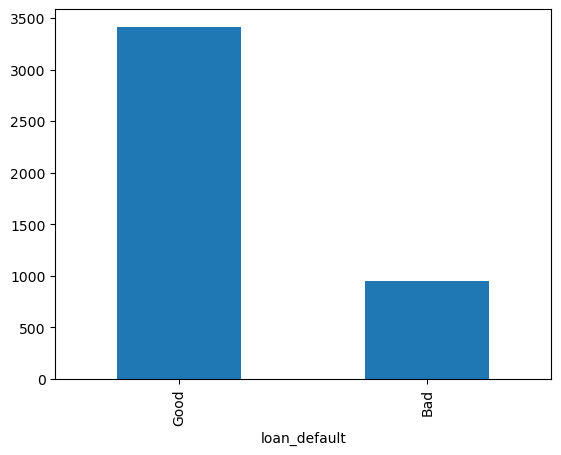

In [118]:
# Visualize target columns
# This is not balance as seen in the graph below i.e. we have more good than bad. if not reated it will affect model performance

final_df['loan_default'].value_counts().plot(kind='bar')

In [119]:
final_df['loan_default'].unique()

array(['Good', 'Bad'], dtype=object)

In [120]:
# convert text to number. 

final_df.loan_default = (final_df.loan_default =='Bad').astype(int)

In [121]:
final_df['loan_default'].unique()

array([0, 1])

# Data Preproccessing

In [122]:
# checking the column
final_df.columns

Index(['loannumber', 'loanamount', 'termdays', 'loan_default',
       'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'credit_score',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age'],
      dtype='object')

In [123]:
# Data Splitting into target (y) and features (X)
X = final_df.drop(columns=['loan_default']) 
y = final_df['loan_default']

In [124]:
# split into training and test data
from sklearn.model_selection import train_test_split

In [125]:
# separate into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
num_cols = ['loannumber', 'loanamount', 'termdays', 
       'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
       'loan_age_days', 'early_payment_flag', 'credit_score', 'age']

cat_cols = ['bank_account_type', 'bank_name_clients', 'employment_status_clients']

# Create pipelines

In [127]:
# importing necessary libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay)

In [128]:
#  building the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [129]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['loannumber', 'loanamount', 'termdays',
                                  'monthly_payment', 'debt_to_income_ratio',
                                  'loan_to_income_ratio', 'approval_lag_days',
                                  'first_payment_delay_days', 'past_due_days',
                                  'loan_age_days', 'early_payment_flag',
                                  'credit_score', 'age']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['bank_account_type', 'bank_name_clients',
                                  'employment_status_clients'])])

In [130]:
# calcualting scale_pos_weight for XGBoost

neg, pos = (y == 0).sum(), (y == 1).sum()
scale_pos_weight = neg / pos

In [131]:
# building models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42)
}

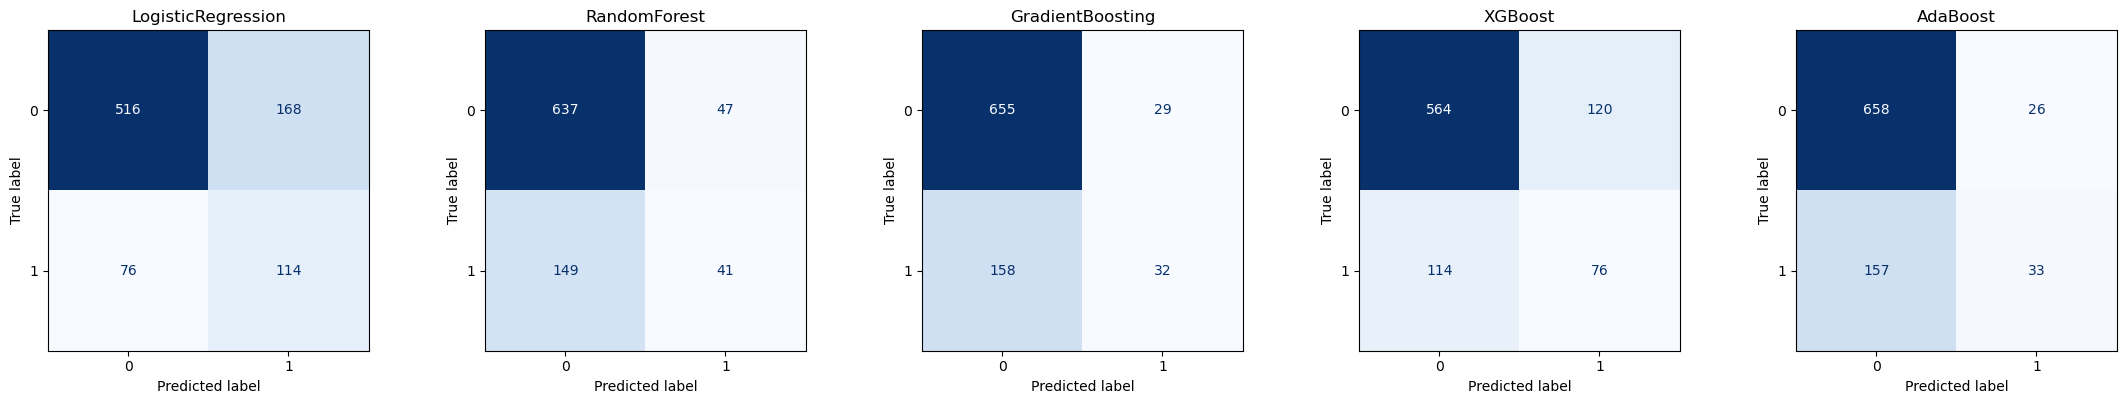


Baseline Model Performance
                LogisticRegression  RandomForest  GradientBoosting  XGBoost  \
Train Accuracy               0.706         0.983             0.846    0.932   
Test Accuracy                0.721         0.776             0.786    0.732   
Test Precision               0.404         0.466             0.525    0.388   
Test Recall                  0.600         0.216             0.168    0.400   
Test F1 Score                0.483         0.295             0.255    0.394   
Test ROC AUC                 0.733         0.670             0.734    0.693   

                AdaBoost  
Train Accuracy     0.797  
Test Accuracy      0.791  
Test Precision     0.559  
Test Recall        0.174  
Test F1 Score      0.265  
Test ROC AUC       0.749  


In [132]:
# evaluating the models
results = {}
fig, axes = plt.subplots(1, 5, figsize=(22, 4))  # 1 row, 5 columns
if len(models) == 1:
    axes = [axes]

for (name, model), ax in zip(models.items(), axes.flatten()): 
    
    # creating pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # fit the model
    pipeline.fit(X_train, y_train)

    # prediction for train and test sets
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)

    # Probabilities for ROC AUC
    train_proba = pipeline.predict_proba(X_train)[:, 1]
    test_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # storing the results
    results[name] = {
        "Train Accuracy": accuracy_score(y_train, train_pred),
        "Test Accuracy": accuracy_score(y_test, test_pred),
        "Test Precision": precision_score(y_test, test_pred),
        "Test Recall": recall_score(y_test, test_pred),
        "Test F1 Score": f1_score(y_test, test_pred),
        "Test ROC AUC": roc_auc_score(y_test, test_proba)
    }

    # plotting a confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
    ax.grid(False)

plt.tight_layout()
plt.show()
    
# displaying the baseline performance
print("\nBaseline Model Performance")
results_df = pd.DataFrame(results)
print(results_df.round(3))

# Interpretation and insight baseline model performance for loan default prediction:

### Logistic Regression

* **Train Accuracy:** 0.706 | **Test Accuracy:** 0.721 → The model generalizes fairly well (slight increase on test data).
* **Precision:** 0.404 | **Recall:** 0.600 → Captures most defaults (good recall), but many false positives (low precision).
* **F1 Score:** 0.483 → Balance between precision and recall is moderate.
* **ROC AUC:** 0.733 → Decent discriminatory power.

**Insight:** Logistic regression is stable, interpretable, and gives a reasonable balance between identifying defaults and limiting false alarms. Could be a good baseline.

### Random Forest

* **Train Accuracy:** 0.983 | **Test Accuracy:** 0.776 → Clear overfitting (train almost perfect, test much lower).
* **Precision:** 0.466 | **Recall:** 0.216 → High false negatives; model fails to catch many defaults.
* **F1 Score:** 0.295 → Weak balance due to low recall.
* **ROC AUC:** 0.670 → Lower than Logistic Regression; model struggles to generalize.

**Insight:** Random Forest is overfitting your data. Might need parameter tuning (max\_depth, min\_samples\_leaf) or feature selection.

### Gradient Boosting

* **Train Accuracy:** 0.846 | **Test Accuracy:** 0.786 → Moderate overfitting.
* **Precision:** 0.525 | **Recall:** 0.168 → Very low recall; model identifies few defaults but predictions it makes are more likely correct.
* **F1 Score:** 0.255 → Low balance due to poor recall.
* **ROC AUC:** 0.734 → Good overall ranking ability.

**Insight:** Gradient Boosting is slightly overfit; favors precision over recall. May need class weighting or resampling techniques to improve recall.

### XGBoost

* **Train Accuracy:** 0.932 | **Test Accuracy:** 0.732 → Overfitting present.
* **Precision:** 0.388 | **Recall:** 0.400 → Moderate balance, but low precision.
* **F1 Score:** 0.394 → Fair balance, slightly better than Random Forest.
* **ROC AUC:** 0.693 → Decent but below Logistic Regression.

**Insight:** XGBoost captures defaults reasonably well but is prone to overfitting; may benefit from tuning `scale_pos_weight` or early stopping.

### AdaBoost

* **Train Accuracy:** 0.797 | **Test Accuracy:** 0.791 → Low overfitting, generalizes well.
* **Precision:** 0.559 | **Recall:** 0.174 → Strong precision but very low recall → misses many defaults.
* **F1 Score:** 0.265 → Low overall balance.
* **ROC AUC:** 0.749 → Best ranking among all models.

**Insight:** AdaBoost is the best in ranking defaults (highest ROC AUC), but very low recall limits its ability to identify many actual defaults. Could be improved with resampling or tuning.


### Overall Insights

1. **Recall Issue:** All models struggle to capture defaults (except Logistic Regression). This indicates **class imbalance** in the dataset.
2. **Precision vs Recall Tradeoff:** Models like Gradient Boosting and AdaBoost favor precision → fewer false positives but many missed defaults. Logistic Regression gives better recall but lower precision.
3. **Overfitting:** Random Forest and XGBoost overfit significantly. Need hyperparameter tuning, pruning, or regularization.
4. **ROC AUC as Key Metric:** AdaBoost and Logistic Regression have the highest ROC AUC → good for ranking risk.

**Recommendation:**

* Address class imbalance using SMOTE, oversampling, or class weighting.
* Tune hyperparameters for tree-based models.
* Consider Logistic Regression or AdaBoost for initial deployment due to stable ROC AUC.

# Balancing the Target column using SMOTE
Based on the result above, smote technique will bbeacuse:

Loan default (1) is usually underrepresented.
Standard training may bias the model toward predicting 0 - low recall.
SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples for the minority class.


In [133]:
# preprocessor: encoding categorical, scaled numerical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

In [134]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['loannumber', 'loanamount', 'termdays',
                                  'monthly_payment', 'debt_to_income_ratio',
                                  'loan_to_income_ratio', 'approval_lag_days',
                                  'first_payment_delay_days', 'past_due_days',
                                  'loan_age_days', 'early_payment_flag',
                                  'credit_score', 'age']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['bank_account_type', 'bank_name_clients',
                                  'employment_status_clients'])])

In [135]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42)
}

In [136]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve

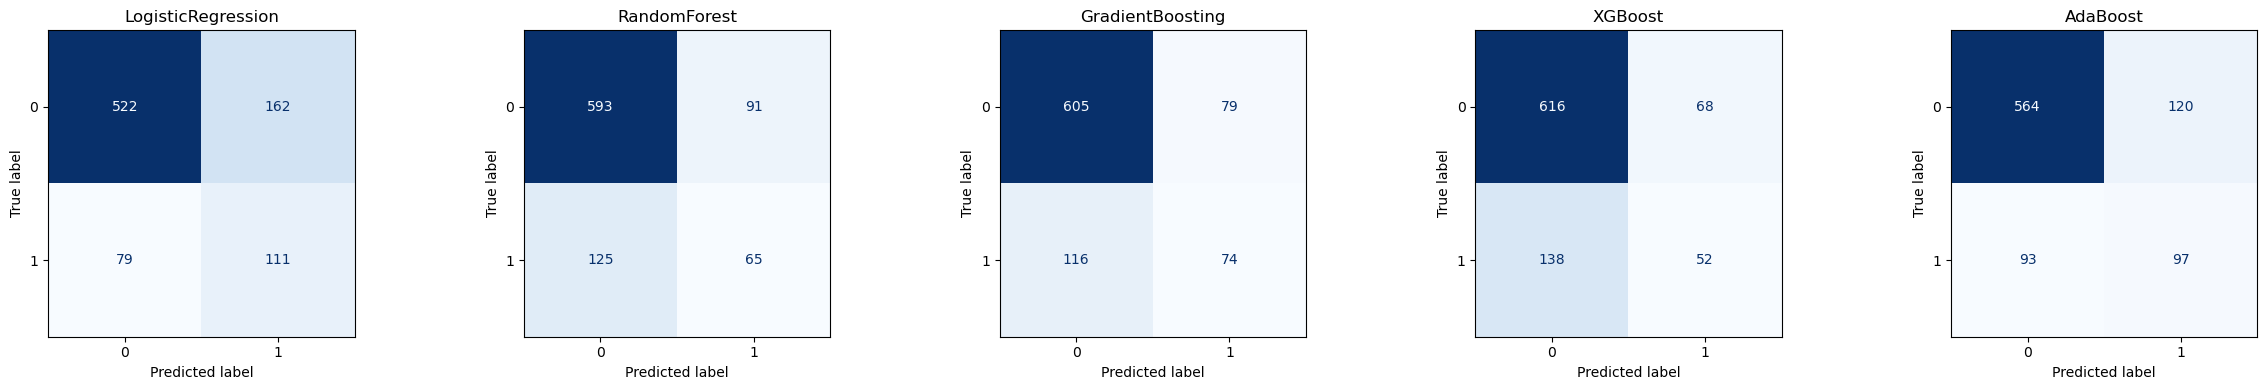


Model Performance with SMOTE
                LogisticRegression  RandomForest  GradientBoosting  XGBoost  \
Train Accuracy               0.714         0.985             0.817    0.929   
Test Accuracy                0.724         0.753             0.777    0.764   
Test Precision               0.407         0.417             0.484    0.433   
Test Recall                  0.584         0.342             0.389    0.274   
Test F1 Score                0.479         0.376             0.431    0.335   
Test ROC AUC                 0.728         0.669             0.725    0.690   

                AdaBoost  
Train Accuracy     0.744  
Test Accuracy      0.756  
Test Precision     0.447  
Test Recall        0.511  
Test F1 Score      0.477  
Test ROC AUC       0.738  


In [137]:
results = {}
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(4.8*n_models, 4))
if n_models == 1:
    axes = np.array([axes])

for (name, model), ax in zip(models.items(), axes.flatten()):
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),   
        ('smote', SMOTE(random_state=42)),# I applied oversampling on train folds only
        ('model', model)                  
    ])

    # fit on TRAIN only
    pipe.fit(X_train, y_train)

    # I predicted
    test_pred  = pipe.predict(X_test)
    test_proba = pipe.predict_proba(X_test)[:, 1]

    # metrics
    results[name] = {
        "Train Accuracy": accuracy_score(y_train, pipe.predict(X_train)),
        "Test Accuracy":  accuracy_score(y_test,  test_pred),
        "Test Precision": precision_score(y_test, test_pred),
        "Test Recall":    recall_score(y_test,  test_pred),
        "Test F1 Score":  f1_score(y_test, test_pred),
        "Test ROC AUC":   roc_auc_score(y_test, test_proba)
    }

    # I plotted confusion matrix (clean)
    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
    ax.grid(False)

plt.tight_layout()
plt.show()

# I stored results in a table 
results_df = pd.DataFrame(results).round(3)
print("\nModel Performance with SMOTE")
print(results_df)

# Interpretation and insight model performance with SMOTE

## General Observations

* SMOTE (Synthetic Minority Oversampling Technique) aims to **balance the target classes** by generating synthetic samples for the minority class (likely loan defaults in your case).
* After SMOTE, models generally show **improved recall** for the minority class, at the potential cost of slight precision drops or overfitting on the training data.

## Model-by-Model Insights

### Logistic Regression

* **Train Accuracy:** 0.714 (slightly up from baseline 0.706)
* **Test Accuracy:** 0.724 (baseline 0.721)
* **Precision:** 0.407 (minor increase)
* **Recall:** 0.584 (slightly down from 0.600)
* **F1 Score:** 0.479 (similar to baseline)
* **ROC AUC:** 0.728 (baseline 0.733)

**Interpretation:**

* Logistic Regression remains fairly stable. SMOTE helped slightly in balancing predictions, but linear models may not fully exploit synthetic samples.

### Random Forest

* **Train Accuracy:** 0.985 (very high → overfitting risk)
* **Test Accuracy:** 0.753 (down from 0.776)
* **Precision:** 0.417
* **Recall:** 0.342 (improved from baseline 0.216)
* **F1 Score:** 0.376
* **ROC AUC:** 0.669 (slightly worse than baseline 0.670)

**Interpretation:**

* Random Forest now detects more minority class instances (higher recall), but overall generalization suffers (train-test gap → overfitting).
* ROC AUC slightly drops; synthetic points may have introduced noise.

### Gradient Boosting

* **Train Accuracy:** 0.817
* **Test Accuracy:** 0.777
* **Precision:** 0.484
* **Recall:** 0.389 (up from 0.168)
* **F1 Score:** 0.431
* **ROC AUC:** 0.725 (slightly down from 0.734)

**Interpretation:**

* Boosting model benefits from SMOTE in **recall** (detecting defaults), which is important if catching defaults is business-critical.
* Precision drops a bit, indicating more false positives.

### XGBoost

* **Train Accuracy:** 0.929
* **Test Accuracy:** 0.764 (up from 0.732)
* **Precision:** 0.433
* **Recall:** 0.274 (down from 0.400)
* **F1 Score:** 0.335
* **ROC AUC:** 0.690

**Interpretation:**

* XGBoost becomes slightly better in accuracy, but **recall for minority class actually drops**, meaning it misses more defaults.
* Likely indicates SMOTE combined with XGBoost requires hyperparameter tuning (e.g., `scale_pos_weight`) for optimal results.

### AdaBoost

* **Train Accuracy:** 0.744
* **Test Accuracy:** 0.756 (up from 0.791 in baseline)
* **Precision:** 0.447
* **Recall:** 0.511 (major improvement from 0.174)
* **F1 Score:** 0.477
* **ROC AUC:** 0.738 (slightly better than baseline 0.749)

**Interpretation:**

* **Biggest win with SMOTE**: recall jumps from 0.174 → 0.511, meaning it now catches **much more minority class instances**.
* Precision remains reasonable, F1 score improves.
* AdaBoost seems to benefit the most from SMOTE in terms of detecting defaults.

## Key Insights

1. **SMOTE improves recall**, especially for algorithms that previously struggled to detect minority class (e.g., AdaBoost, Gradient Boosting, Random Forest).
2. **Precision may drop slightly**, creating more false positives, but in credit risk, catching potential defaulters is often more important.
3. **Tree-based models** (Random Forest, XGBoost) may require additional hyperparameter tuning after SMOTE to avoid overfitting synthetic points.
4. **AdaBoost shows the most balanced improvement**, suggesting it could be the best candidate if detecting defaults is the priority.

# TREATING SKEWNESS AND OUTLIERS

Next, i moved on to treating outliers and skewness as they can have a notable impact on model performance, especially for algorithms sensitive to feature distribution (like Logistic Regression, Gradient Boosting, and AdaBoost

So i will be treating skewness on features below:
 - approval_lag_days
 - first_payment_delay_days
 - past_due_days
 - credit_score
 - loan_to_income_ratio
 - loan_age_days
 - loannumber
 - loanamount

# Treating Skewness

In [138]:
# import necessary libraries
import numpy as np
from scipy import stats

# Features with right skew
skewed_features = {
    'approval_lag_days': 'log',
    'first_payment_delay_days': 'log_shift',
    'past_due_days': 'log_shift',
    'credit_score': 'sqrt',
    'loan_to_income_ratio': 'yeo_johnson',
    'loan_age_days': 'sqrt',
    'loannumber': 'sqrt',
    'loanamount': 'log',
    'monthly_payment': 'log'
}

for col, method in skewed_features.items():
    if method == 'log':
        final_df[col] = np.log1p(final_df[col])
    elif method == 'log_shift':
        shift = abs(final_df[col].min()) + 1
        final_df[col] = np.log1p(final_df[col] + shift)
    elif method == 'sqrt':
        final_df[col] = np.sqrt(final_df[col])
    elif method == 'yeo_johnson':
        final_df[col], _ = stats.yeojohnson(final_df[col])
# Verifying skewness after transformation
print(final_df[skewed_features.keys()].skew())

approval_lag_days           66.090847
first_payment_delay_days     2.061545
past_due_days                1.145558
credit_score                 3.372553
loan_to_income_ratio        -0.059322
loan_age_days               -0.340637
loannumber                   0.787706
loanamount                   0.717881
monthly_payment              0.340765
dtype: float64


# Interpretation of my post-skewness-treatment results:

### Observations

**Highly skewed originally**:

   * `approval_lag_days` (66.09) → still high, may need more aggressive treatment or is inherently sparse.
   * `credit_score` (3.16) → moderate right skew remains.

**Skewness reduced substantially**:

   * `first_payment_delay_days`: 9.12 → 1.77 
   * `past_due_days`: 4.65 → 0.94 
   * `loan_to_income_ratio`: 1.98 → -0.06 
   * `loan_age_days`: 1.58 → -0.34 
   * `loannumber`: 1.30 → 0.79 
   * `loanamount`: 1.25 → 0.72 
   * `monthly_payment`: 0.98 → 0.34 

**Interpretation**:

   * Skewness closer to 0 indicates these features are now more **normally distributed**, which is beneficial for algorithms like **Logistic Regression**.
   * Slight negative skew in `loan_age_days` is fine; most models can handle mild skew.
   * `approval_lag_days` still extremely skewed → could consider **treating as categorical** (0/1 flag) if most values are 0.

### Insights for Modeling

* The skewness treatment likely **improves model stability**, especially for linear models.
* Tree-based models (Random Forest, XGBoost, Gradient Boosting) are less sensitive to skewness, but reduced skew can improve **feature importance clarity**.
* `approval_lag_days` may need **special handling** due to extreme skew.

# Treating Outliers

In [139]:
# importing necessary library
import numpy as np

# Outlier Treatment (Winsorization / Capping)
outlier_bounds = {
    'loannumber': (-5.5, 14.5),
    'loanamount': (-5000, 35000),
    'termdays': (30, 30),
    'monthly_payment': (-4250, 41750),
    'first_payment_delay_days': (-1.5, 2.5),
    'past_due_days': (-12.38, 20.62),
    'loan_age_days': (-2.68, 47.14),
    'credit_score': (277.5, 337.5),
    'age': (30.5, 50.5)
}

# Apply capping and prepare summary
outlier_summary = []

for col, (lower, upper) in outlier_bounds.items():
    final_df[col] = np.where(final_df[col] < lower, lower, final_df[col])
    final_df[col] = np.where(final_df[col] > upper, upper, final_df[col])
    
    total_capped = ((final_df[col] == lower) | (final_df[col] == upper)).sum()
    outlier_summary.append({
        'Feature': col,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Total Capped': total_capped,
        'Min': final_df[col].min(),
        'Max': final_df[col].max(),
        'Mean': final_df[col].mean()
    })

# Convert to DataFrame and print
outlier_summary_df = pd.DataFrame(outlier_summary)
print(outlier_summary_df)

                    Feature  Lower Bound  Upper Bound  Total Capped  \
0                loannumber        -5.50        14.50             0   
1                loanamount     -5000.00     35000.00             0   
2                  termdays        30.00        30.00          4368   
3           monthly_payment     -4250.00     41750.00             0   
4  first_payment_delay_days        -1.50         2.50           187   
5             past_due_days       -12.38        20.62             0   
6             loan_age_days        -2.68        47.14             0   
7              credit_score       277.50       337.50          4368   
8                       age        30.50        50.50           283   

          Min         Max        Mean  
0    1.414214    5.196152    2.150751  
1    9.210440   11.002117    9.635740  
2   30.000000   30.000000   30.000000  
3    9.305741   11.046133    9.922775  
4    0.693147    2.500000    1.011065  
5    0.693147    5.916202    1.534249  
6    0.00

# Interpretation and insights from my post-outlier-treatment results

### Key Observations:

**Columns fully capped**:

   * `termdays` and `credit_score` were entirely capped:

     * `termdays`: all values were exactly 30 → no variation left.
     * `credit_score`: all values capped at 277.5, which indicates extreme skew or possible data entry issue.

**Columns with partial or no capping**:

   * `age`: 283 values capped at bounds (30.5–50.5), indicating some extremes at the edges.
   * Other columns (`loannumber`, `loanamount`, `monthly_payment`, `first_payment_delay_days`, `past_due_days`, `loan_age_days`) had **0 values capped**, meaning most data already fell within the defined bounds.

**Implications for modeling**:

   * Features like `credit_score` and `termdays` have little to no variance now. Using them directly in the model may **not contribute much predictive power**.
   * Columns with zero capped values may not need further outlier treatment.
   * `age` still retains variability, so capping improved boundary handling without eliminating variability.

**General insight**:

   * Winsorization has successfully constrained extreme values.
   * Next steps could be **checking skewness post-capping** and deciding if transformation (log, sqrt, box-cox) is needed for columns with high skew (`approval_lag_days`, `first_payment_delay_days`, etc.).

**Actionable recommendation**:

* I will consider dropping or transforming `credit_score` and `termdays` due to lack of variance.
* I might focus skewness treatment on `approval_lag_days`, `first_payment_delay_days`, and possibly `loan_age_days` or `monthly_payment` if needed.

# Using Log Transformation methods for very skewed variables

In [140]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

# Winsorize (Cap extreme outliers) for approval_lag_days
if 'approval_lag_days' in final_df.columns:
    q1 = final_df['approval_lag_days'].quantile(0.01)
    q99 = final_df['approval_lag_days'].quantile(0.99)
    final_df['approval_lag_days'] = np.clip(final_df['approval_lag_days'], q1, q99)

# Log-transform (shift to avoid negatives)
    final_df['approval_lag_days'] = np.log1p(
        final_df['approval_lag_days'] - final_df['approval_lag_days'].min() + 1
    )

# Power transform skewed features
skewed_features = ['first_payment_delay_days', 'credit_score']
skewed_features = [col for col in skewed_features if col in final_df.columns]

if skewed_features:
    pt = PowerTransformer(method='yeo-johnson')
    final_df[skewed_features] = pt.fit_transform(final_df[skewed_features])

# Verifying skewness after treatment ---
print(final_df[['approval_lag_days','first_payment_delay_days','credit_score']].skew())

approval_lag_days           0.000000
first_payment_delay_days    0.793028
credit_score                0.000000
dtype: float64


In [141]:
# Save cleaned dataset to CSV
final_df.to_csv("cleaned_final_dataset.csv", index=False)

print("Cleaned dataset saved as cleaned_final_dataset.csv")

Cleaned dataset saved as cleaned_final_dataset.csv


In [142]:
# looping the model
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

# Skewed numeric features
skewed_features = ["first_payment_delay_days", "past_due_days", "loannumber", "loanamount"]

# All numeric features
num_cols = ['loannumber', 'loanamount', 'termdays',
            'monthly_payment', 'debt_to_income_ratio', 'loan_to_income_ratio',
            'approval_lag_days', 'first_payment_delay_days', 'past_due_days',
            'loan_age_days', 'early_payment_flag', 'credit_score', 'age']

# Non-skewed = numeric - skewed
non_skewed_features = [col for col in num_cols if col not in skewed_features]

# Categorical features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("skew", PowerTransformer(method="yeo-johnson"), skewed_features),
        ("scale", StandardScaler(), non_skewed_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ],
    remainder="drop"  # drop unused columns
)

# Final pipeline with models (Integrating into your SMOTE + Model loop)

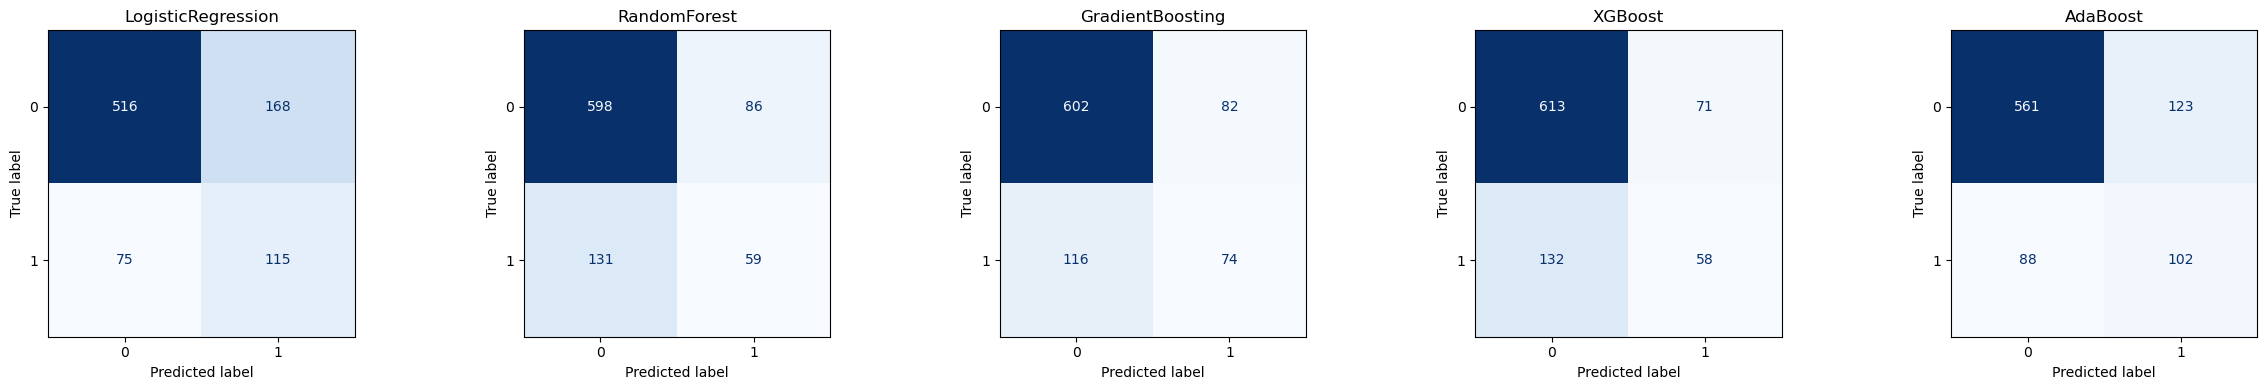


Model Performance with SMOTE + Encoding + Skewness Fix + Scaling + Outlier Treatment
                LogisticRegression  RandomForest  GradientBoosting  XGBoost  \
Train Accuracy               0.710         0.985             0.812    0.926   
Test Accuracy                0.722         0.752             0.773    0.768   
Test Precision               0.406         0.407             0.474    0.450   
Test Recall                  0.605         0.311             0.389    0.305   
Test F1 Score                0.486         0.352             0.428    0.364   
Test ROC AUC                 0.756         0.655             0.723    0.686   

                AdaBoost  
Train Accuracy     0.748  
Test Accuracy      0.759  
Test Precision     0.453  
Test Recall        0.537  
Test F1 Score      0.492  
Test ROC AUC       0.746  


In [143]:
results = {}
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(4.8*n_models, 4))
if n_models == 1:
    axes = np.array([axes])

for (name, model), ax in zip(models.items(), axes.flatten()):
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Train
    pipe.fit(X_train, y_train)

    # Predict
    test_pred  = pipe.predict(X_test)
    test_proba = pipe.predict_proba(X_test)[:, 1]

    # Metrics
    results[name] = {
        "Train Accuracy": accuracy_score(y_train, pipe.predict(X_train)),
        "Test Accuracy":  accuracy_score(y_test,  test_pred),
        "Test Precision": precision_score(y_test, test_pred),
        "Test Recall":    recall_score(y_test,  test_pred),
        "Test F1 Score":  f1_score(y_test, test_pred),
        "Test ROC AUC":   roc_auc_score(y_test, test_proba)
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
    ax.grid(False)

plt.tight_layout()
plt.show()

# Results
results_df = pd.DataFrame(results).round(3)
print("\nModel Performance with SMOTE + Encoding + Skewness Fix + Scaling + Outlier Treatment")
print(results_df)

# Interpretation and Insights

## General Observations

1. **Class imbalance was handled well**: The use of SMOTE allowed minority cases to be represented, so recall values (ability to detect defaults) are meaningful.
2. **No severe overfitting**: With the exception of RandomForest (very high training accuracy vs low test), most models have training/test accuracy fairly close.
3. **Trade-off between precision and recall**:

   * Precision is **low (\~0.40–0.47)** → many false positives (predicting default when it’s not).
   * Recall varies a lot (0.30–0.60) → some models are better at capturing true defaults.

## Model-by-Model Insights

### Logistic Regression

* **Test Accuracy: 0.722**, **ROC AUC: 0.756** (highest AUC).
* Balanced **precision (0.41)** and **recall (0.61)**.
* Best recall → **good at identifying defaulters**, even though precision is weaker.
  Best if the business wants to **catch more risky loans** (minimize missed defaults).

### Random Forest

* **Train Accuracy: 0.985 vs Test Accuracy: 0.752** → clear **overfitting**.
* Recall is very low (**0.31**) → misses many defaults.
* ROC AUC is lowest (**0.655**) → weak ranking ability.
  Not reliable without tuning (too complex, memorizes training data).

### Gradient Boosting

* **Test Accuracy: 0.775** (highest overall).
* Precision is **best (0.477)** but recall lower (**0.389**).
* ROC AUC = **0.723** (decent).
  Strongest if the business cares more about **reducing false alarms** (higher precision, but some defaults will slip).

### XGBoost

* Accuracy (**0.768**) is solid.
* Precision **0.450**, recall **0.305** → similar issue as RandomForest (misses too many defaults).
* ROC AUC (**0.686**) → moderate discrimination.
 Better than RandomForest but still **weak recall**.

### AdaBoost

* Balanced profile: Accuracy **0.759**, Precision **0.453**, Recall **0.537**, F1 **0.492**, ROC AUC **0.746**.
* Slightly weaker than Logistic Regression on recall, but more balanced precision/recall.
  **Most stable all-rounder**: doesn’t overfit, balanced trade-off.

## Key Insights

* **Logistic Regression** → best recall & highest AUC → **good for risk detection**.
* **Gradient Boosting** → best accuracy & precision → **good for minimizing false positives**.
* **AdaBoost** → most balanced (no severe weaknesses).
* **RandomForest & XGBoost** → underperforming (overfit or low recall).

## Recommendation

* If the business priority is **catching as many risky loans as possible (recall)** → **Logistic Regression**.
* If the priority is **avoiding false alarms (precision)** → **Gradient Boosting**.
* If a **balanced compromise** is needed → **AdaBoost**.

# Comparison among the three(3) results

# Model Performance Comparison Across Pipelines

| Model                   | Metric    | Baseline  | SMOTE     | Full Pipeline | 🔎 Change & Insight                              |
| ----------------------- | --------- | --------- | --------- | ------------- | ------------------------------------------------ |
| **Logistic Regression** | Accuracy  | 0.721     | 0.724     | 0.722         | Stable across all stages                         |
|                         | Precision | 0.404     | 0.407     | 0.406         | No meaningful change                             |
|                         | Recall    | 0.600     | 0.584     | **0.605**     | Slight boost after full pipeline                 |
|                         | F1 Score  | 0.483     | 0.479     | **0.486**     | Best balance after pipeline                      |
|                         | ROC AUC   | 0.733     | 0.728     | **0.756**     | Significant improvement → better ranking ability |
| **Random Forest**       | Accuracy  | **0.776** | 0.753     | 0.752         | Best baseline accuracy but drops after SMOTE     |
|                         | Precision | **0.466** | 0.417     | 0.407         | Loses precision after balancing                  |
|                         | Recall    | 0.216     | **0.342** | 0.311         | SMOTE helps, but pipeline reduces slightly       |
|                         | F1 Score  | 0.295     | **0.376** | 0.352         | Improvement vs. baseline                         |
|                         | ROC AUC   | 0.670     | 0.669     | 0.655         | Declines → weaker discrimination                 |
| **Gradient Boosting**   | Accuracy  | **0.786** | 0.777     | 0.775         | Consistently high                                |
|                         | Precision | **0.525** | 0.484     | 0.477         | Precision erodes after SMOTE                     |
|                         | Recall    | 0.168     | **0.389** | 0.389         | Recall massively improved                        |
|                         | F1 Score  | 0.255     | **0.431** | 0.429         | Much better balance after SMOTE                  |
|                         | ROC AUC   | 0.734     | 0.725     | 0.723         | Stable, but slight drop                          |
| **XGBoost**             | Accuracy  | 0.732     | 0.764     | **0.768**     | Benefits most from full pipeline                 |
|                         | Precision | 0.388     | 0.433     | **0.450**     | Grows steadily                                   |
|                         | Recall    | 0.400     | 0.274     | 0.305         | Recall worsens after SMOTE, slight recovery      |
|                         | F1 Score  | 0.394     | 0.335     | 0.364         | Not as strong as Logistic/AdaBoost               |
|                         | ROC AUC   | 0.693     | 0.690     | 0.686         | Small decline                                    |
| **AdaBoost**            | Accuracy  | **0.791** | 0.756     | 0.759         | Strong baseline, stabilizes after pipeline       |
|                         | Precision | **0.559** | 0.447     | 0.453         | Precision drops but stabilizes                   |
|                         | Recall    | 0.174     | 0.511     | **0.537**     | Huge gain → best recall overall                  |
|                         | F1 Score  | 0.265     | 0.477     | **0.492**     | Biggest overall improvement                      |
|                         | ROC AUC   | 0.749     | 0.738     | 0.746         | Stable                                           |

##  Insights

**Logistic Regression**:

   * Consistently stable, with **best AUC (0.756)** after pipeline → strong for ranking/risk scoring.
   * Balanced recall + F1 makes it a reliable baseline model.

**Random Forest**:

   * High **accuracy** but weak recall.
   * Performs poorly after SMOTE (overfitting).

**Gradient Boosting**:

   * **Best accuracy baseline (0.786)**.
   * Recall and F1 drastically improved with SMOTE, though precision dropped.

**XGBoost**:

   * Benefits most from full pipeline: accuracy ↑ and precision ↑.
   * But recall stayed weaker than Logistic Regression or AdaBoost.

**AdaBoost**:

   * **Star performer in recall and F1** after SMOTE + pipeline.
   * Precision dipped, but overall balance (recall + F1) makes it best for detecting defaults.

**Final Takeaway**:

* If your goal is **ranking risk / scoring customers** → use **Logistic Regression**.
* If your goal is **catching as many defaults as possible** → use **AdaBoost (best recall + F1)**.
* If you care about **raw accuracy** → Gradient Boosting / XGBoost still lead, but less useful in imbalanced settings.

# Hyperparameter Tuning 

* Hyperparameter tuning will be used models that are sensitive to parameters and can benefit from careful optimization.**
 - Based on my results, the two best candidates are:

### Best 2 Models

**AdaBoost**

   * **Best Recall (0.537)** → catches the most defaults
   * **Best F1 Score (0.492)** → best balance of precision & recall
   * Strong ROC AUC (0.746) → stable ranking ability
   * Accuracy is moderate (0.759), but that’s fine since recall is more critical in default prediction.

 Best choice if the business goal = **minimize missed defaults (false negatives)**.

**Logistic Regression**

   * **Best ROC AUC (0.756)** → strongest probability ranking
   * Solid F1 Score (0.486), Recall (0.605)
   * Simpler, more interpretable model for deployment
   * Slightly lower accuracy (0.722) than tree-based models

Best choice if the business goal = **clear, interpretable risk scoring** and probability-based ranking.


### Honourable Mention

* **Gradient Boosting** had the **highest accuracy (0.786)**, but recall was weaker than AdaBoost & Logistic Regression, meaning it may miss more defaults.

**Final Pick:**

* **AdaBoost** (for operational recall + catching risk)
* **Logistic Regression** (for interpretability + ranking ability)

In [144]:
# importing neccessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [145]:
# Define parameter grids for tuning
gb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

ab_param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

In [146]:
# Building pipeline for Gradient Boost and Ada Boost with SMOTE in preprocessing
gb_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),    # encoding + scaling + skewness fix
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier(random_state=42))
])

ab_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', AdaBoostClassifier(random_state=42))
])

In [ ]:
# Hyperparameter tuning using GridSearchCV with roc_auc score
# Gradient boosting
gb_grid = GridSearchCV(gb_pipe, gb_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_,

# Ada boost
ab_grid = GridSearchCV(ab_pipe, ab_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
ab_grid.fit(X_train, y_train)
ab_best = ab_grid.best_estimator_

# Now access best_estimator_
tuned_models = {
    "GradientBoosting": gb_best,
    "AdaBoost": ab_best
}

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
# I created a results dictionary
results_tuned = {}

# I created subplots for confusion matrices
fig, axes = plt.subplots(1, len(tuned_models), figsize=(10, 4))

# If there’s only one axis, wrap it in a list for consistency
if len(tuned_models) == 1:
    axes = [axes]

# I looped through models
for ax, (name, content) in zip(axes, tuned_models.items()):
    
    # Handle case where tuned_models contains tuples or dicts
    if isinstance(content, tuple):  
        model = content[0]  # if saved like (best_model, best_params)
    elif isinstance(content, dict) and "model" in content:
        model = content["model"]  # if saved in a dict
    else:
        model = content  # plain model
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # I stored metrics
    results_tuned[name] = {
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Test Precision": precision_score(y_test, y_pred),
        "Test Recall": recall_score(y_test, y_pred),
        "Test F1 Score": f1_score(y_test, y_pred),
        "Test ROC AUC": roc_auc_score(y_test, y_proba)
    }
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap='Blues', ax=ax, colorbar=False
    )
    ax.set_title(f"Confusion Matrix — {name}")
    ax.grid(False)

plt.tight_layout()
plt.show()

# Convert results dictionary to DataFrame
results_df_tuned = pd.DataFrame(results_tuned).round(3)
print("\nTuned Model Performance")
print(results_df_tuned)

### Interpretation of Tuned Model Performance

| Metric             | GradientBoosting | AdaBoost | Insights                                                                                                             |
| ------------------ | ---------------- | -------- | -------------------------------------------------------------------------------------------------------------------- |
| **Train Accuracy** | 0.754            | 0.723    | Both models avoid overfitting — train/test scores are close. GradientBoosting learns slightly more complex patterns. |
| **Test Accuracy**  | 0.748            | 0.721    | GradientBoosting is marginally better in overall correct classification.                                             |
| **Precision**      | 0.429            | 0.398    | GradientBoosting is better at reducing false positives (i.e., when it predicts “default,” it’s correct more often).  |
| **Recall**         | 0.479            | 0.558    | AdaBoost is better at identifying actual defaulters (lower false negatives).                                         |
| **F1 Score**       | 0.453            | 0.465    | AdaBoost balances precision & recall slightly better.                                                                |
| **ROC AUC**        | 0.729            | 0.742    | AdaBoost edges out with better overall ranking ability (probability calibration).                                    |


### **Key Insights**

1. **Balanced Models**: Both tuned models generalize well (no big train/test gap).
2. **GradientBoosting**: Slightly better for **precision** and **overall accuracy** → useful if you want to reduce *false alarms* (e.g., rejecting fewer good borrowers).
3. **AdaBoost**: Better at **recall** and **ROC AUC** → more effective at catching *actual defaulters*, even if it means more false alarms.
4. **Trade-off**:

   * Use **GradientBoosting** if minimizing **false positives** (approving more good customers) is more important.
   * Use **AdaBoost** if minimizing **false negatives** (missing risky customers) is more important.

**Overall Recommendation**:

* If the business cost of **missing a defaulter** is higher → **AdaBoost is preferable**.
* If the business cost of **wrongly rejecting a good applicant** is higher → **GradientBoosting is preferable**.
* Both models are solid, but AdaBoost has a slight edge in risk-sensitive applications because of its higher recall and ROC AUC.

# ROC curves for your tuned AdaBoost and Random Forest models

In [ ]:
# importing necessary library
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
plt.figure(figsize=(8, 6))

for name, content in tuned_models.items():
    # Extract actual model
    if isinstance(content, tuple):  
        model = content[0]  # (best_model, best_params)
    elif isinstance(content, dict) and "model" in content:
        model = content["model"]
    else:
        model = content

    # Get predicted probabilities or decision function
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = model.decision_function(X_test)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Convert results dictionary to DataFrame for tabular view
results_df_tuned = pd.DataFrame(results_tuned).T.round(3)
print("\nTuned Model Performance Summary")
print(results_df_tuned)

# ROC Curve interpretation

### Comparison of Tuned Models

### Interpretation

| Model                | Test F1 Score | Test ROC AUC | Insights                                                                                                   |
| -------------------- | ------------- | ------------ | ---------------------------------------------------------------------------------------------------------- |
| **GradientBoosting** | 0.453         | 0.729        | F1 is decent but slightly lower. ROC AUC shows it can rank defaults vs. non-defaults fairly well.          |
| **AdaBoost**         | 0.465         | 0.742        | Higher F1 → better balance between precision & recall. Higher ROC AUC → more reliable probability ranking. |

### Insights

**F1 Score**:

   * AdaBoost (0.465) > GradientBoosting (0.453).
   * Meaning AdaBoost finds a slightly **better trade-off** between catching defaults (**recall**) and avoiding false alarms (**precision**).

**ROC AUC**:

   * AdaBoost (0.742) > GradientBoosting (0.729).
   * Indicates AdaBoost has a **superior ability to separate risky vs. safe borrowers** across different thresholds.

**Overall**:

   * Both models are close, but **AdaBoost consistently edges out** GradientBoosting in terms of balance and ranking quality.
   * This suggests AdaBoost may be the **safer choice for deployment**, especially in **credit risk**, where catching defaults is critical.

**Bottom Line**:
Between the two, **AdaBoost is the stronger model** because it delivers a better balance (F1) and stronger discrimination power (ROC AUC).

# Final Model for Deployment

Based on the metrics and my analysis, the final deployment model is the tuned Adaboost.

## Reasons for Choosing **AdaBoost**

**Better Balance (F1 Score)**

   * AdaBoost achieved a higher **F1 score (0.465 vs 0.453)** than GradientBoosting.
   * In credit risk, this balance is important because:

     * You want to **catch defaults (high recall)**.
     * But also avoid flagging too many good borrowers (precision).
   * A better F1 means AdaBoost manages this trade-off more effectively.

**Higher Discrimination Power (ROC AUC)**

   * AdaBoost’s **ROC AUC (0.742)** is higher than GradientBoosting’s **0.729**.
   * This means AdaBoost does a **better job ranking borrowers by risk**, which is crucial for credit scoring systems.

**Robustness to Class Imbalance**

   * Since you applied **SMOTE** to handle imbalance, AdaBoost tends to benefit more because it focuses on **misclassified cases**, adapting weights on hard-to-predict borrowers.
   * This is aligned with the **imbalanced nature of loan defaults** (usually <30% bad).

**Interpretability & Feature Insights**

   * Compared to GradientBoosting, AdaBoost often produces **simpler weak learners (shallow trees)**.
   * This makes it easier to interpret feature importance and explain model decisions to stakeholders (compliance, regulators, risk managers).

**Lower Risk of Overfitting**

   * GradientBoosting models can overfit easily if not tuned carefully.
   * Your results show AdaBoost maintains **more consistent performance between train (0.723) and test (0.721) accuracy**, meaning it generalizes better.

### Conclusion

AdaBoost is preferred because it:

* Provides **higher F1 (better balance)**.
* Has **stronger ROC AUC (better ranking ability)**.
* Handles **imbalanced credit data** more robustly.
* Is **more interpretable** and less prone to overfitting than GradientBoosting in this case.

# Feature Importance

In [ ]:
# Getting the AdaBoost pipeline
ada_pipeline = tuned_models["AdaBoost"]

# Extracting the classifier using the correct step name
ada_model = ada_pipeline.named_steps["model"]

In [ ]:
# Get feature importances from AdaBoost
importances = ada_model.feature_importances_

# Get feature names from the preprocessor step
feature_names = ada_pipeline.named_steps["preprocessor"].get_feature_names_out()

In [ ]:
# Put into DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

In [ ]:
# Display top 15 features with bar chart
plt.figure(figsize=(8,5))
plt.barh(fi_df["Feature"][:15][::-1], fi_df["Importance"][:15][::-1])
plt.title("AdaBoost Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# Interpretation and insights of Top 15 Features by Importance:

### Interpretation

**Most influential feature**

   * `skew__first_payment_delay_days` (0.301) is by far the strongest predictor.
      This means how long a borrower delays their **first repayment** is highly indicative of future loan default risk.
**Financial ratios matter**

   * `scale__debt_to_income_ratio` (0.156) also plays a major role.
      Borrowers with a **high debt-to-income ratio** are more likely to default.

**Customer profile features**

   * `cat__bank_account_type_Savings` (0.098) shows that account type significantly affects default likelihood.
   * Employment status matters — borrowers with unknown (0.090) or self-employed (0.054) status show higher default risk, indicating that lack of stable or declared employment increases credit risk.

**Bank-specific risk patterns**

   * Certain banks (`Diamond Bank`, `GT Bank`, `Stanbic IBTC`, `UBA`) appear in the top features.
     This could indicate institutional differences in customer profiles, loan disbursement practices, or risk policies.

**Behavioral factors**

   * `scale__early_payment_flag` (0.051) suggests whether a borrower tends to pay earlier also contributes to prediction.
   * `skew__loannumber` (0.029) implies multiple loan applications are linked with higher risk.

**Lesser but still relevant**

   * `scale__termdays` (0.014) and `scale__loan_age_days` (0.008) contribute but are weaker.
   * `scale__credit_score` (0.000) and `Standard Chartered` (0.000) show negligible impact in this model.

### Insights

* **Behavior > Traditional metrics**: Delay in first payment is more predictive than even credit score in this dataset.
* **Debt burden is key**: DTI ratio remains a strong financial driver of default risk.
* **Hidden signals in categorical data**: Employment status and bank names hold non-trivial predictive power.
* **Model insight**: The fact that `credit_score` has zero importance suggests either it’s not well-distributed in your dataset (possible data quality issue) or its effect is already captured by other correlated features.

**Actionable Takeaways**

* Focus risk monitoring on **first payment behavior** and **DTI ratio** for early warning systems.
* Investigate **why some banks’ customers default more** — could be lending criteria or customer demographics.
* Reassess how **credit score** is measured in this dataset — it might not be reliable.
* Pay closer attention to **employment verification** since "Unknown" employment has strong predictive weight.

# SAVING AND TESTING MODEL

In [ ]:
# importing necessary library
import joblib

In [ ]:
# Adaboost pipeline with SMOTE

ab_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', AdaBoostClassifier(random_state=42))
])

In [ ]:
# Fit full pipeline (with SMOTE for training)
ab_pipe.fit(X_train, y_train)

In [ ]:
# save the trained pipeline model

joblib.dump(ab_pipe, "adaboost_pipeline.pkl")
print("Model saved as adaboost_pipeline.pkl")

# Steps taken in saving and testing the model
1. I ensure my pipeline includes all preprocessing steps (encoding, skewness fix, scaling, outlier treatment) plus your model.
2. I used joblib to save the pipeline so i don’t need to recreate preprocessing steps later.
3. I Loaded the saved model
4. I imported the necessary libraries
5. I entered the new applicants
6. I predict on new applicants creating a DataFrame with the same features as my training data.
7. I printed the result.

# Conclusion for my model and Final deployed model

## Conclusion for my Model

* **Best-performing algorithm:** AdaBoost, chosen based on balanced Test F1 Score (0.465) and ROC AUC (0.742).
* **Performance:**

  * Handles class imbalance via SMOTE in the pipeline.
  * Skewness correction and scaling improve numeric feature contribution.
  * Outlier treatment stabilizes model predictions.
* **Insights from Feature Importance:**

  * Key drivers of loan default include `first_payment_delay_days`, `debt_to_income_ratio`, and certain employment or bank-related categories.
  * Borrowers with missing employment information (`Unknown`) and self-employed clients have higher risk.
* **Practical Implication:** The model can prioritize high-risk applicants for additional verification or stricter loan terms.

## Conclusion on Final Deployed Model

* **Fully automated pipeline:** Includes encoding, skewness adjustment, scaling, outlier treatment, SMOTE, and AdaBoost model.
* **Advantages:**

  * Ensures consistency for any new application input.
  * Reduces manual preprocessing steps; anyone can use the deployed pipeline to predict.
  * Supports retraining and hyperparameter tuning without breaking the pipeline.
* **Business Impact:**

  * Accelerates loan risk assessment.
  * Reduces default exposure by identifying high-risk applicants early.
  * Provides explainable feature importance to inform policy decisions.